In [2]:
import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [3]:
from sklearn.cluster import SpectralClustering

In [4]:
import visual_behavior_glm.GLM_analysis_tools as gat

In [5]:
import visual_behavior.visualization.utils as utils
import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

In [6]:
from visual_behavior.dimensionality_reduction.clustering import processing
from visual_behavior.dimensionality_reduction.clustering import plotting

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### get experiments and cells tables and limit to closest familiar and novel active

In [8]:
experiments_table = loading.get_platform_paper_experiment_table()
len(experiments_table)

1249

In [9]:
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)
len(experiments_table)

402

In [10]:
matched_experiments = experiments_table.index.values

In [11]:
cells_table = loading.get_cell_table()
len(cells_table.cell_specimen_id.unique())

28833

In [12]:
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()

3921 cells in matched cells table


In [13]:
# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

### get GLM output, filter and reshape

In [14]:
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

In [ ]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

### NOTE: create a new folder if you are testing out this notebook or else it will overwrite existing files & plots

In [15]:
# folder = '220310_across_session_norm'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [16]:
features = processing.get_features_for_clustering()

### get across session normalized dropout scores

In [ ]:
# # get GLM results from saved file in save_dir or from mongo if file doesnt exist
# results_pivoted = processing.get_glm_results_pivoted_for_clustering(glm_version, model_output_type, save_dir)
# results_pivoted.head()

In [25]:
import visual_behavior_glm.GLM_across_session as gas

df = gas.load_cells(cells='all')

1086494804 could not be loaded
1086494677 could not be loaded
1086494537 could not be loaded
1086494288 could not be loaded
1086494248 could not be loaded
1086494176 could not be loaded
1086494076 could not be loaded
1086493993 could not be loaded
1086493543 could not be loaded
1086493441 could not be loaded
1086493384 could not be loaded
1086493213 could not be loaded
1086493082 could not be loaded
1086492984 could not be loaded
1086492915 could not be loaded


In [30]:
df = df.rename(columns={'ophys_experiment_id_x':'ophys_experiment_id', 'cell_specimen_id_x':'cell_specimen_id'})
df = df.set_index('cell_specimen_id')

within = df[[key for key in df.keys() if '_within' in key]+['ophys_experiment_id', 'experience_level']]
across = df[[key for key in df.keys() if '_across' in key]+['ophys_experiment_id', 'experience_level']]

In [82]:
results_pivoted = across.copy()
results_pivoted = results_pivoted.rename(columns={'omissions_across':'omissions', 'all-images_across':'all-images', 
                                         'behavioral_across':'behavioral', 'task_across':'task'})
print(len(results_pivoted))

11718


In [83]:
results_pivoted.head()

,omissions,all-images,behavioral,task,ophys_experiment_id,experience_level
cell_specimen_id,,,,,,
1086551315,0.0,0.000000,0.0,0.000000,794381992,Familiar
1086551315,0.0,-0.295018,0.0,-0.094833,795076128,Novel 1
1086551315,0.0,-0.258126,0.0,-0.430496,796105304,Novel >1
1086550804,0.0,0.000000,0.0,0.000000,794381992,Familiar
1086550804,0.0,0.000000,0.0,0.000000,795076128,Novel 1


### limit to strictly matched cells

In [84]:
# get rid of passive sessions

# get cells table and limit to cells matched in closest familiar and novel active
cells_table = loading.get_cell_table()
cells_table = utilities.limit_to_last_familiar_second_novel_active(cells_table)
cells_table = utilities.limit_to_containers_with_all_experience_levels(cells_table)
cells_table = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(cells_table)
print(len(cells_table.cell_specimen_id.unique()), 'cells in cells_table after limiting to strictly matched cells')

# get matched cells and experiments to limit to
matched_experiments = cells_table.ophys_experiment_id.unique()
matched_cells = cells_table.cell_specimen_id.unique()

# limit results pivoted to to last familiar and second novel
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted.loc[matched_cells]
print(len(results_pivoted.index.unique()), 'cells in results_pivoted after limiting to strictly matched cells')


3921 cells in cells_table after limiting to strictly matched cells
3921 cells in results_pivoted after limiting to strictly matched cells


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:16: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



### drop duplicates

In [95]:
results_pivoted = results_pivoted.reset_index().drop_duplicates(subset=['cell_specimen_id', 'experience_level']).set_index('cell_specimen_id')
len(results_pivoted)

11733

In [97]:
len(results_pivoted.index.unique())

3921

### save results_pivoted

In [211]:
results_pivoted.to_hdf(os.path.join(save_dir, glm_version + '_results_pivoted.h5'), key='df')

C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['experience_level']]




### continue processing

In [116]:
dropouts = results_pivoted.copy()

In [118]:
dropouts = dropouts.drop(columns='ophys_experiment_id')

# sort by features
features = processing.get_features_for_clustering()
columns = [*features, 'experience_level']
dropouts = dropouts[columns]

# make everything positive
for feature in features:
    dropouts[feature] = np.abs(dropouts[feature])

In [120]:
# unstack dropout scores to get a vector of features x experience levels for each cell
feature_matrix = processing.get_feature_matrix_for_clustering(dropouts, glm_version, save_dir=save_dir)
feature_matrix.head()

found 7812 duplicated cells. But not removed. This needs to be fixed
3906


all-images                     omissions                     \
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1 Novel >1   
cell_specimen_id                                                               
1086489847         0.000000  0.060457  0.017832  0.000000  0.000000      0.0   
1086489860         0.000000  0.910349  0.000000  0.000000  0.109417      0.0   
1086489891         0.000000  0.279929  0.000000  0.524089  0.000000      0.0   
1086489976         0.817370  0.000000  0.000000  0.000000  0.000000      0.0   
1086490002         0.852927  0.000000  0.355870  0.000000  0.000000      0.0   

                 behavioral                          task                      
experience_level   Familiar   Novel 1  Novel >1  Familiar   Novel 1  Novel >1  
cell_specimen_id                                                               
1086489847         0.000000  0.084897  0.971563  0.000000  0.004045  0.009827  
1086489860         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086489891         0.168301  0.008724  1.000000  0.000000  0.025777  0.000000  
1086489976         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1086490002         0.000000  0.000000  0.000000  0.021871  0.000000  0.000000

In [121]:
# get cell metadata for all cells in feature_matrix
cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
cell_metadata.head()

3906 cells in cell_metadata for feature_matrix


,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,...,area_binned_depth,layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086551315,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086550804,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086541251,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086540341,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3
1086539950,794381992,CAM2P.4,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,412366,Ai93(TITL-GCaMP6f),"[Slc17a7-IRES2-Cre, Camk2a-tTA]",F,149.0,Slc17a7-IRES2-Cre,GCaMP6f,...,VISp_375,lower,20181212,False,-1.0,True,True,False,False,Familiar 3


### plot feature matrix for each cre line

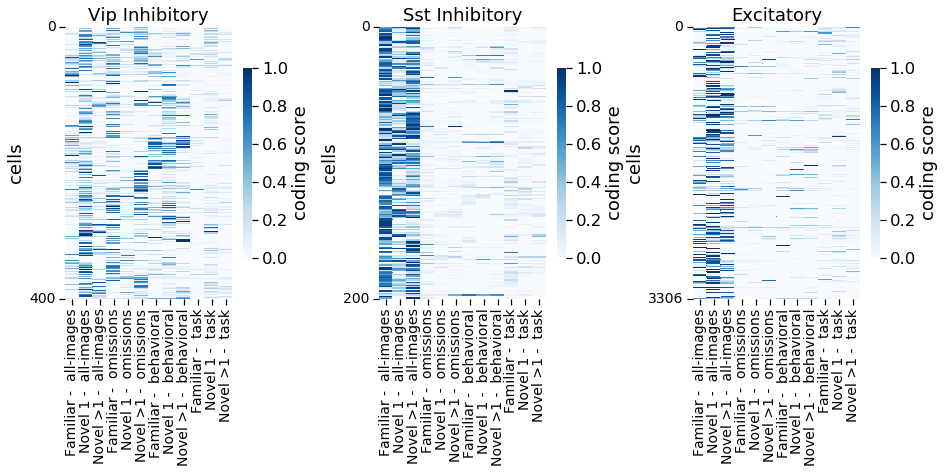

In [122]:
plotting.plot_feature_matrix_for_cre_lines(feature_matrix, cell_metadata, save_dir=base_dir, folder=folder)

### get Silhouette scores

In [130]:
silhouette_scores = processing.load_silhouette_scores(glm_version, feature_matrix, cell_metadata, save_dir)

size of X = (400, 12)
NaNs in the array = 0
n 2 clusters mean score = 0.17658571012962376
n 3 clusters mean score = 0.20890017538481417
n 4 clusters mean score = 0.2074041559563443
n 5 clusters mean score = 0.22968052630647592
n 6 clusters mean score = 0.23857762434875568
n 7 clusters mean score = 0.23949704303340558
n 8 clusters mean score = 0.2585196565769154
n 9 clusters mean score = 0.2686733484678343
n 10 clusters mean score = 0.2575824677000889
n 11 clusters mean score = 0.25471528278374006
n 12 clusters mean score = 0.24582193043517803
n 13 clusters mean score = 0.23703900031676586
n 14 clusters mean score = 0.2504590236519718
n 15 clusters mean score = 0.2547866036307835
n 16 clusters mean score = 0.24915284119228304
n 17 clusters mean score = 0.24540307160898261
n 18 clusters mean score = 0.23858690585075312
n 19 clusters mean score = 0.2463828745476957
n 20 clusters mean score = 0.2430383670352158
n 21 clusters mean score = 0.2332319170182049
n 22 clusters mean score = 0.2363

### select  number of clusters

In [132]:
n_clusters_cre = {'Slc17a7-IRES2-Cre': 10,
                 'Sst-IRES-Cre': 6, 
                 'Vip-IRES-Cre':12}

### plot silhouettes with selected # clusters

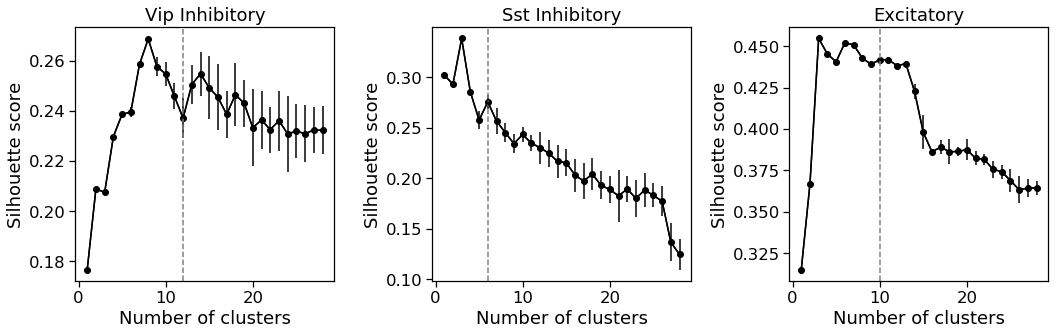

In [133]:
plotting.plot_silhouette_scores_n_clusters(silhouette_scores, cell_metadata, n_clusters_cre=n_clusters_cre, save_dir=base_dir, folder=folder)

### get coclustering matrices per cre line

In [134]:
coclustering_matrices = processing.get_coclustering_matrix(glm_version, feature_matrix, cell_metadata, n_clusters_cre, save_dir, nboot=100)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]

 43%|██████████████████████████████████▊                                              | 43/100 [00:04<00:07,  7.85it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.87it/s]

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:26<00:28,  2.37s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:54<00:00,  2.35s/it]


### get cluster labels per cre line from Agglomerative clustering on co-clustering matrix

In [135]:
cluster_labels = processing.get_cluster_labels(coclustering_matrices, cell_metadata, n_clusters_cre, save_dir, load=False)
cluster_labels.head()

generating cluster labels from coclustering matrix
saving cluster_labels to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220310_across_session_norm\cluster_labels_Vip_12_Sst_6_Slc17a7_10.h5


,labels,cell_specimen_id,cre_line,cluster_id
0,0,1086492406,Vip-IRES-Cre,3
1,4,1086492307,Vip-IRES-Cre,5
2,0,1086492221,Vip-IRES-Cre,3
3,6,1086492174,Vip-IRES-Cre,7
4,8,1086491936,Vip-IRES-Cre,2


#### merge cluster labels with cell metadata, remove small clusters, and add manual sort order

In [137]:
cluster_labels.cluster_id.unique()

array([ 3,  5,  7,  2,  8,  1, 11,  6,  9, 10,  4, 12], dtype=int64)

In [140]:
cluster_meta = processing.get_cluster_meta(cluster_labels, cell_metadata, feature_matrix, n_clusters_cre, save_dir, load=False)
cluster_meta.head()

generating cluster_meta
0 cells dropped total
adding within cluster correlation to cluster_meta


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning:

invalid value encountered in true_divide



saving cluster_meta to \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\24_events_all_L2_optimize_by_session\220310_across_session_norm\cluster_metadata_Vip_12_Sst_6_Slc17a7_10.h5


C:\Users\marinag\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:2530: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['equipment_name', 'full_genotype', 'reporter_line', 'driver_line', 'sex', 'cre_line', 'indicator', 'project_code', 'targeted_structure', 'date_of_acquisition', 'session_type', 'experience_level', 'image_set', 'cell_type', 'area_depth', 'area_binned_depth', 'layer', 'experience_exposure', 'manual_sort_order']]




,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,...,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,original_cluster_id,manual_sort_order,within_cluster_correlation
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086492406,3,0,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,3,4,0.449441
1086492307,5,4,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,5,7,0.962579
1086492221,3,0,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,3,4,0.761867
1086492174,7,6,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,7,3,0.874636
1086491936,2,8,795073741,CAM2P.4,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,151.0,...,False,-1.0,True,True,False,False,Familiar 3,2,2,0.376984


In [141]:
cluster_meta[['labels', 'cluster_id', 'original_cluster_id', 'manual_sort_order', 'within_cluster_correlation']].head()

,labels,cluster_id,original_cluster_id,manual_sort_order,within_cluster_correlation
cell_specimen_id,,,,,
1086492406,0,3,3,4,0.449441
1086492307,4,5,5,7,0.962579
1086492221,0,3,3,4,0.761867
1086492174,6,7,7,3,0.874636
1086491936,8,2,2,2,0.376984


### plot co-clustering matrix and dendrograms sorted by linkage matrix

In [142]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
#     plotting.plot_coclustering_matrix_and_dendrograms(coclustering_matrices, cre_line, cluster_meta, n_clusters_cre, 
#                                                      save_dir=base_dir, folder=folder)

In [ ]:
# data = coclustering_matrices[cre_line]

# fig, ax = plt.subplots(figsize=(8,8))
# ax = sns.clustermap(data=data, cmap='Greys', cbar_kws={'label':'co-clustering probability'})

### sort coclustering matrix by cluster ID / cluster size

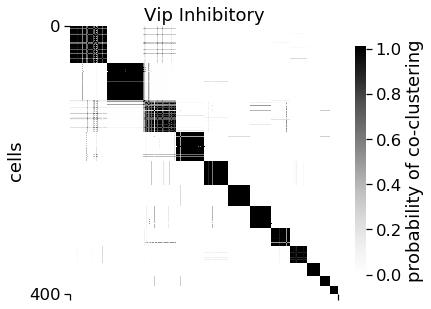

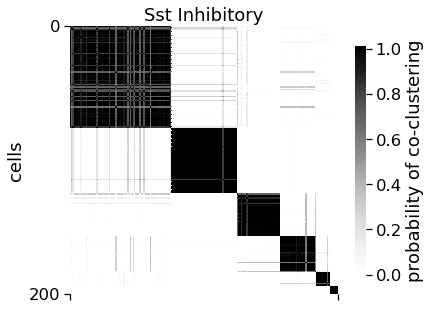

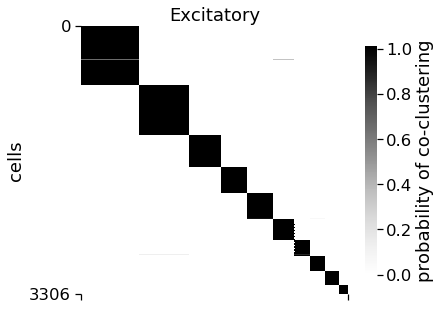

In [190]:
cre_lines = processing.get_cre_lines(cell_metadata)
for cre_line in cre_lines: 
    plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_matrices, cluster_meta, cre_line, 
                                                    save_dir=base_dir, folder=folder, ax=None)

### plot average dropout scores for each cluster

### plot each cluster separately and save to single cell examples dir

In [ ]:
cell_examples_dir = os.path.join(save_dir, 'matched_cell_examples')
if not os.path.exists(cell_examples_dir):
    os.mkdir(cell_examples_dir)

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:539: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



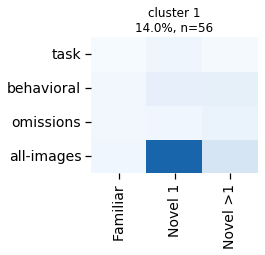

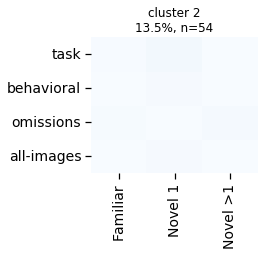

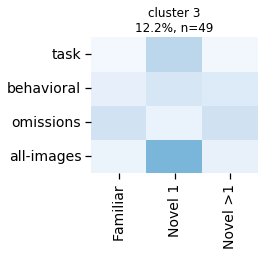

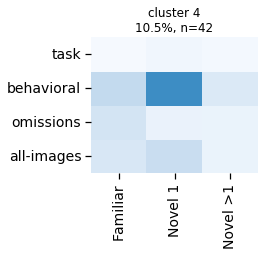

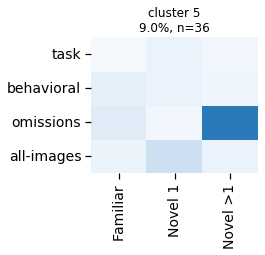

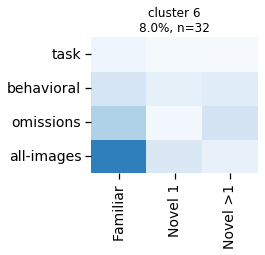

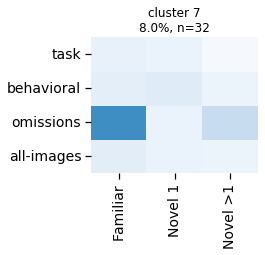

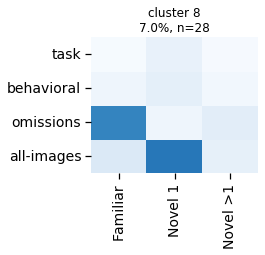

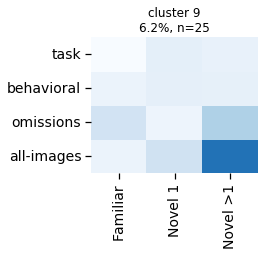

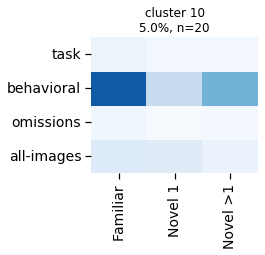

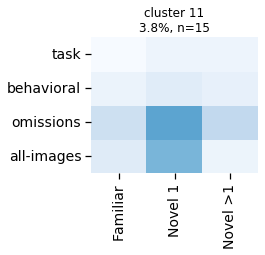

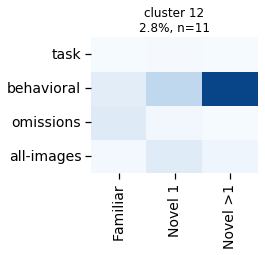

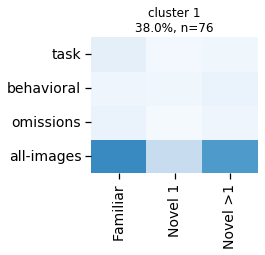

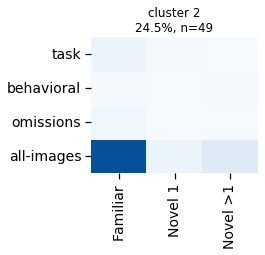

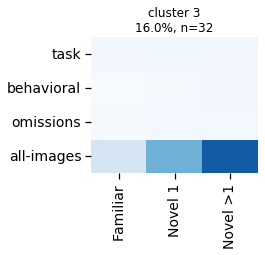

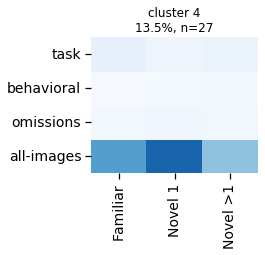

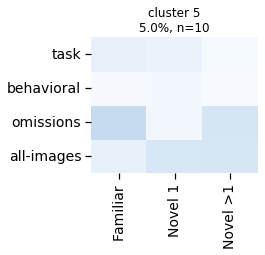

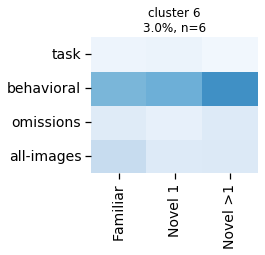

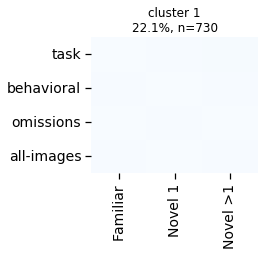

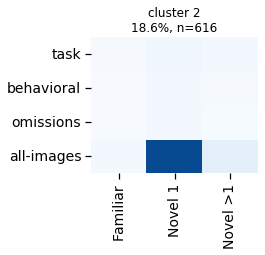

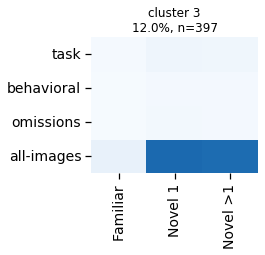

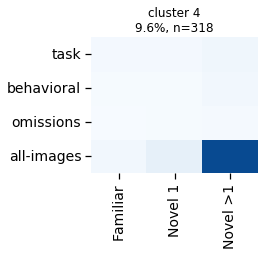

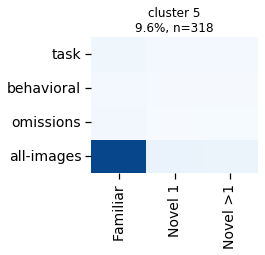

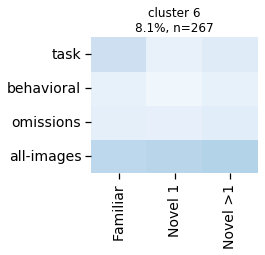

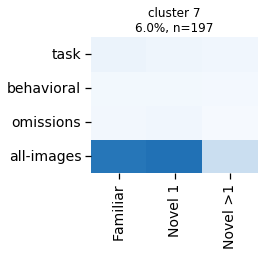

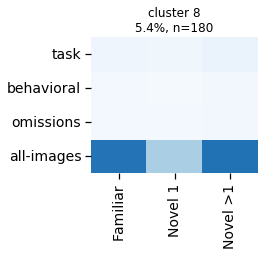

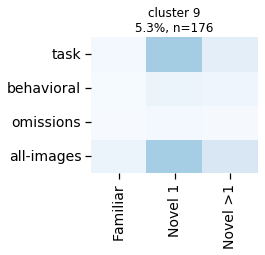

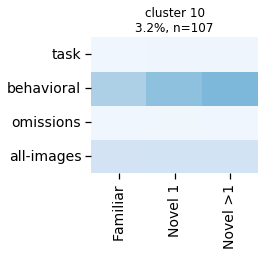

In [146]:
plotting.plot_dropout_heatmaps_and_save_to_cell_examples_folders(cluster_meta, feature_matrix, save_dir)

### plot average dropouts for each cre line in cluster size order

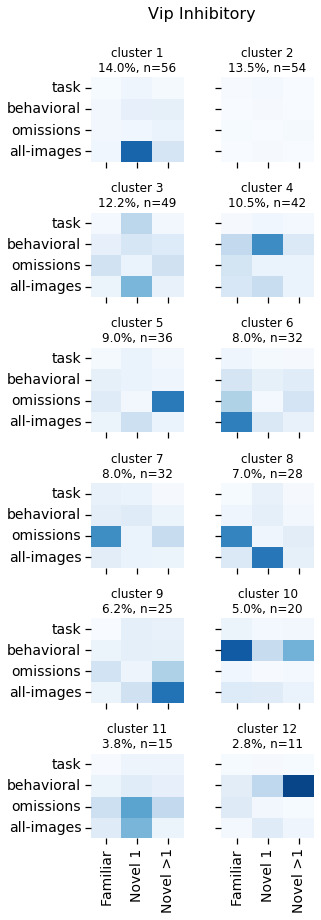

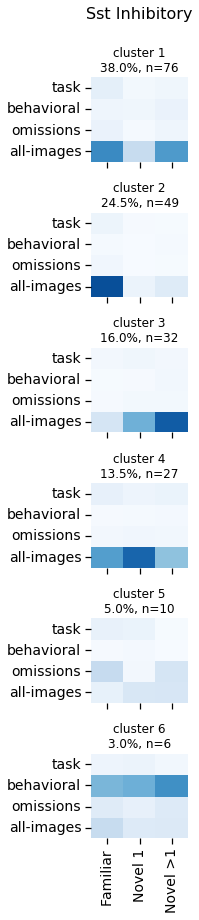

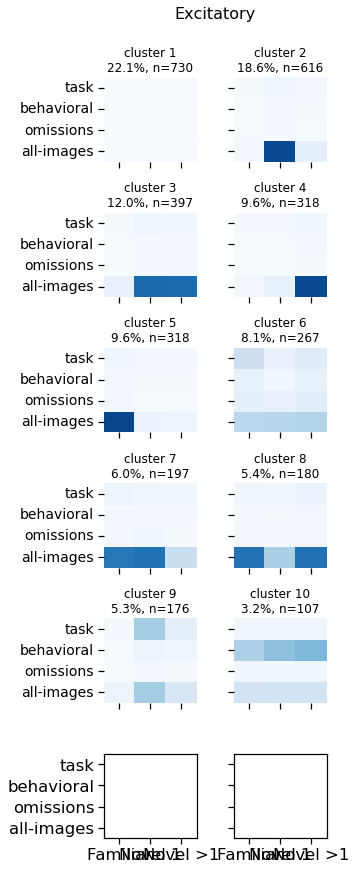

In [147]:
sort_col = 'cluster_id'

plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col=sort_col, save_dir=base_dir, folder=folder)

### plot dropout heatmaps in manually sorted order

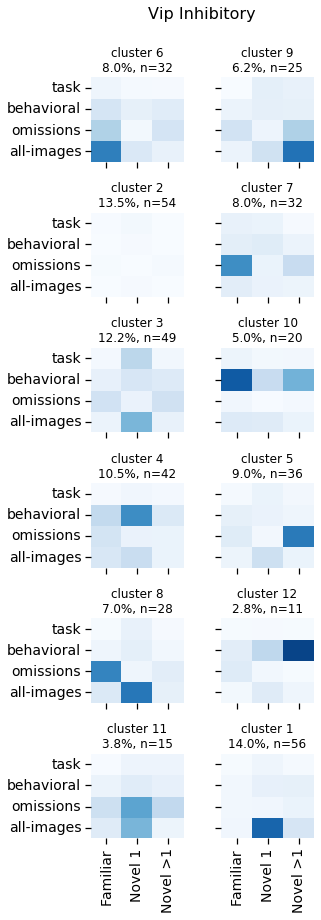

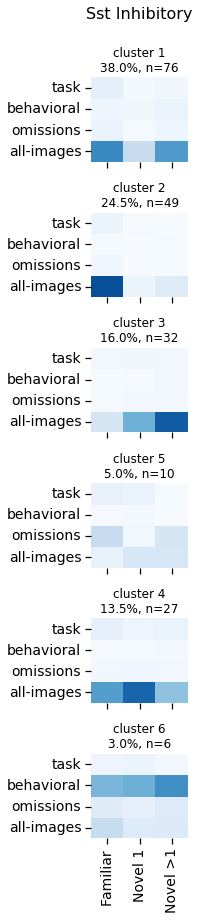

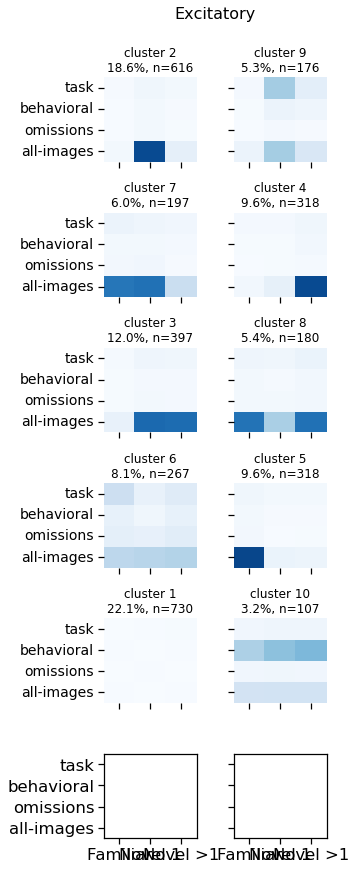

In [148]:
# sort_col = 'manual_sort_order'

# plotting.plot_dropout_heatmaps_for_clusters(cluster_meta, feature_matrix, sort_col=sort_col, save_dir=base_dir, folder=folder)

### plot feature matrix sorted by cluster ID

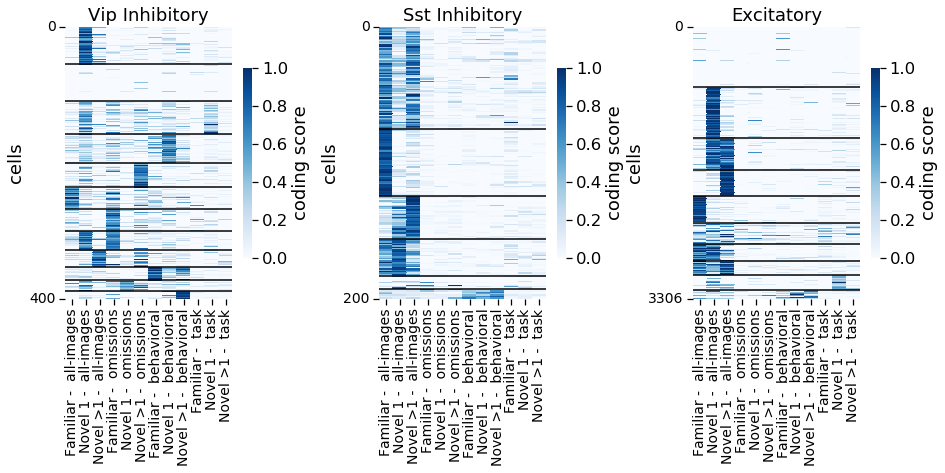

In [149]:
plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='cluster_id', save_dir=base_dir, folder=folder)
    

In [150]:
# plotting.plot_feature_matrix_sorted(feature_matrix, cluster_meta, sort_col='manual_sort_order', save_dir=base_dir, folder=folder)
    

### umap with cluster labels

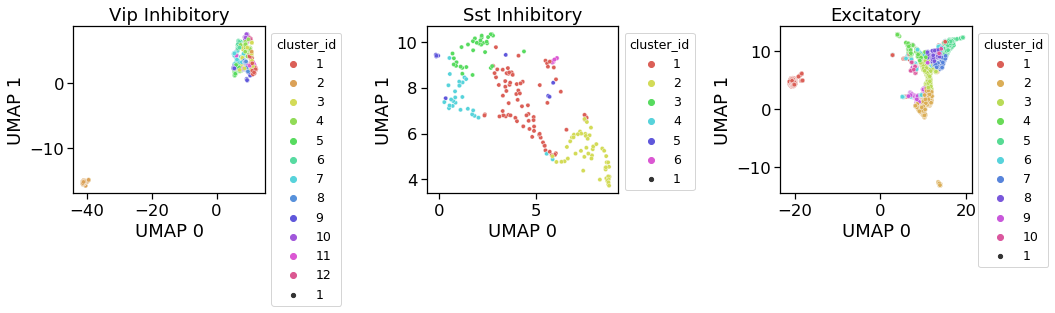

In [151]:
# for column in ['project_code', 'binned_depth', 'targeted_structure', 'mouse_id']:
label_col = 'cluster_id'

plotting.plot_umap_for_clusters(cluster_meta, feature_matrix, label_col=label_col, save_dir=base_dir, folder=folder)


### Correlations within clusters

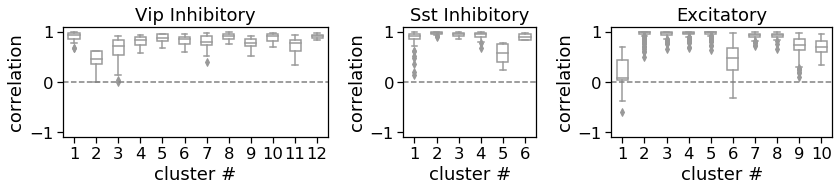

In [152]:
plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=None, save_dir=base_dir, folder=folder)

In [ ]:
# sort_order = processing.get_manual_sort_order()

# plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=sort_order, 
#                                                   suffix='_manual_sort', save_dir=base_dir, folder=folder)

### average dropouts per cre line

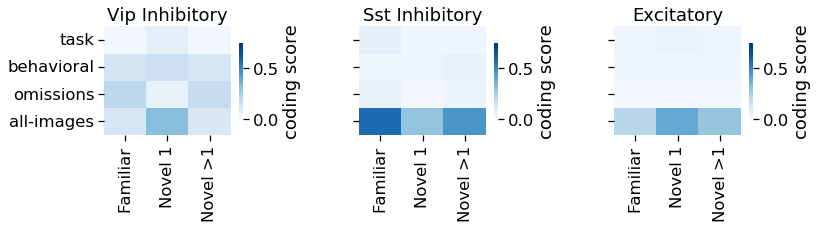

In [153]:
plotting.plot_average_dropout_heatmap_for_cre_lines(dropouts, cluster_meta, save_dir=base_dir, folder=folder)

### plot 100 cells per cluster to examine within cluster variability

In [157]:
plotting.plot_random_subset_of_cells_per_cluster(cluster_meta, dropouts, save_dir)

20 cells in cluster 10
selecting a random subset of 20
56 cells in cluster 1
selecting a random subset of 56
49 cells in cluster 3
selecting a random subset of 49
32 cells in cluster 6
selecting a random subset of 32
32 cells in cluster 7
selecting a random subset of 32
54 cells in cluster 2
selecting a random subset of 54
25 cells in cluster 9
selecting a random subset of 25
42 cells in cluster 4
selecting a random subset of 42
36 cells in cluster 5
selecting a random subset of 36
28 cells in cluster 8
selecting a random subset of 28
15 cells in cluster 11
selecting a random subset of 15
11 cells in cluster 12
selecting a random subset of 11
76 cells in cluster 1
selecting a random subset of 76
49 cells in cluster 2
selecting a random subset of 49
27 cells in cluster 4
selecting a random subset of 27
32 cells in cluster 3
selecting a random subset of 32
6 cells in cluster 6
selecting a random subset of 6
10 cells in cluster 5
selecting a random subset of 10
397 cells in cluster 3
sele

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1106: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000025A6F7490D0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000025A6F7A29D8> (for post_execute):


KeyboardInterrupt: 

### breakdown by area and depth

We are going to normalize within each area or depth to account for the large imbalance in N due to Scientifica datasets only being performed in V1 at certain depths, as well as biological variation in cell type specific expression by depth

### plot fraction cells by area and depth

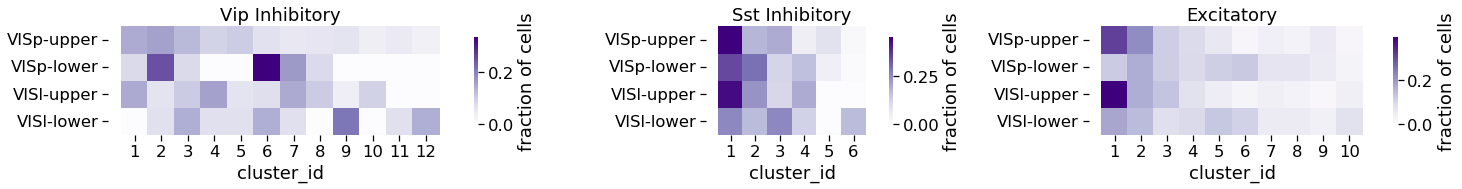

In [158]:
label = 'fraction of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=True, label=label, 
                                           save_dir=base_dir, folder=folder)

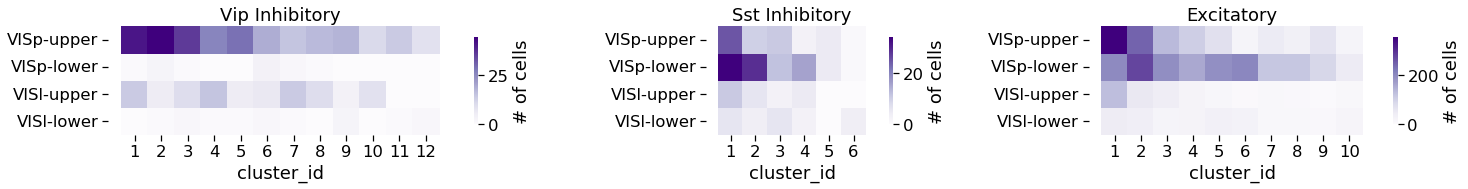

In [159]:
label = '# of cells'
plotting.plot_fraction_cells_by_area_depth(cluster_meta, n_clusters_cre, normalize=False, label=label, 
                                           save_dir=base_dir, folder=folder)

### compute % cells per area / depth relative to chance

to deal with uneven sampling across areas & depths, we will express the fraction of cells per cluster in each area & depth as a percentage relative to chance. We can compute the expected number of cells per area and depth in each cluster based on random sampling of our area/depth distribution, then compute how many cells are actually in each area and depth per cluster and express that as a % relative to chance

To compute the expected number of cells in each cluster based on sampling: 
    * take size of cluster (n_neurons) and select a random set of cells of that size
    * repeat 100x to get a distribution of random cells
    * compute the number of cells in each area and depth in the random distribution
    * quantify how many cells are actually in each area and depth in the clustered data
    * compute significance of actual # cells relative to random distrubution 
    * report % cells relative to chance and p_value
    

In [160]:
cell_count_stats = processing.get_cell_count_stats(cluster_meta, conditions_to_groupby = ['targeted_structure', 'layer'])

In [161]:
cell_count_stats.head()[cell_count_stats.keys()[:16]]

,targeted_structure,layer,cre_line,n_cells_total_cre,n_cells_cond_cre,fraction_per_cond_cre,cluster_id,n_cells_total_cluster,n_cells_cond_cluster,fraction_per_cond_cluster,n_cells,random_n_cells,random_n_cells_mean,fraction_of_random,relative_to_random,n_times_actual_greater_than_random
0,VISl,lower,Slc17a7-IRES2-Cre,3306,264,0.079855,1,730,48,0.065753,48,"[69, 60, 62, 61, 57, 51, 54, 57, 60, 55, 58, 6...",59.12,0.811908,-0.188092,4.0
1,VISl,upper,Slc17a7-IRES2-Cre,3306,328,0.099214,1,730,130,0.178082,130,"[80, 84, 67, 81, 67, 82, 69, 79, 69, 76, 70, 8...",71.76,1.811594,0.811594,100.0
2,VISp,lower,Slc17a7-IRES2-Cre,3306,1602,0.484574,1,730,200,0.273973,200,"[350, 351, 355, 342, 356, 361, 345, 352, 360, ...",355.19,0.563079,-0.436921,0.0
3,VISp,upper,Slc17a7-IRES2-Cre,3306,1112,0.336358,1,730,352,0.482192,352,"[231, 235, 246, 246, 250, 236, 262, 242, 241, ...",243.93,1.443037,0.443037,100.0
0,VISl,lower,Slc17a7-IRES2-Cre,3306,264,0.079855,2,616,40,0.064935,40,"[42, 57, 59, 42, 44, 42, 41, 47, 52, 47, 50, 5...",49.10,0.814664,-0.185336,3.0


In [162]:
# save stats
cell_count_stats.to_csv(os.path.join(save_dir, 'cell_count_stats.csv'))

### heatmap of % rel chance

#### fraction of cells relative to random distribution

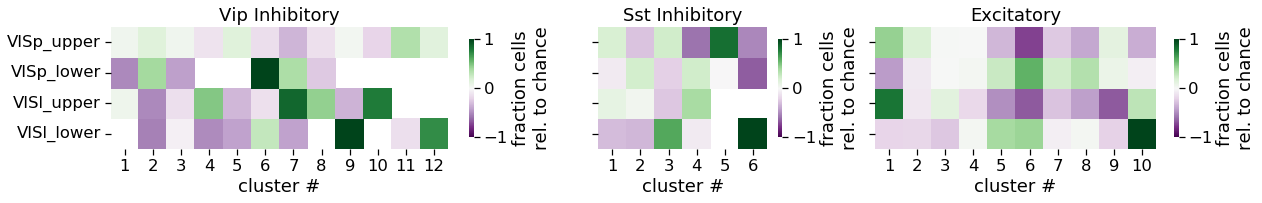

In [163]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range'

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre, 
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=None, suffix=suffix, save_dir=base_dir, folder=folder)

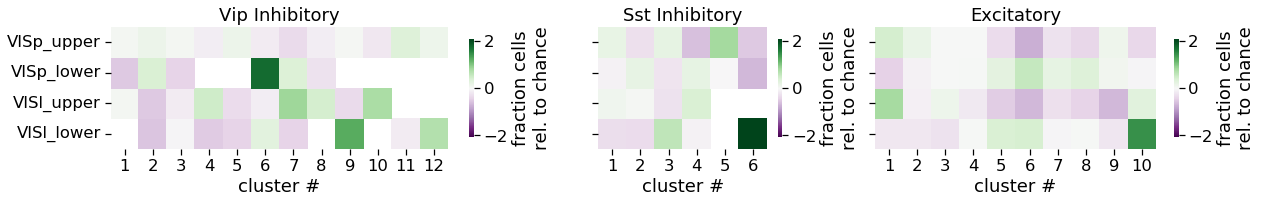

In [164]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_full_range'

vmax = cell_count_stats.relative_to_random.max()
vmin = cell_count_stats.relative_to_random.min()

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre, 
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=None, save_dir=base_dir, folder=folder, suffix=suffix)

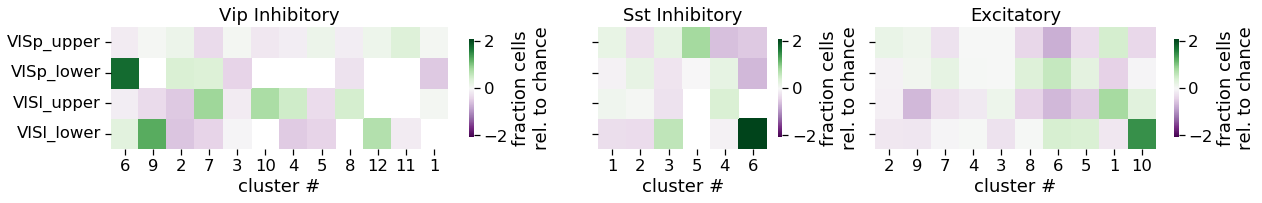

In [165]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_full_range_manual_sort_order'

vmax = cell_count_stats.relative_to_random.max()
vmin = cell_count_stats.relative_to_random.min()

cluster_order = processing.get_manual_sort_order()

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre,
                                             value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                             cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

### sort clusters by the fraction of cells in VISp upper

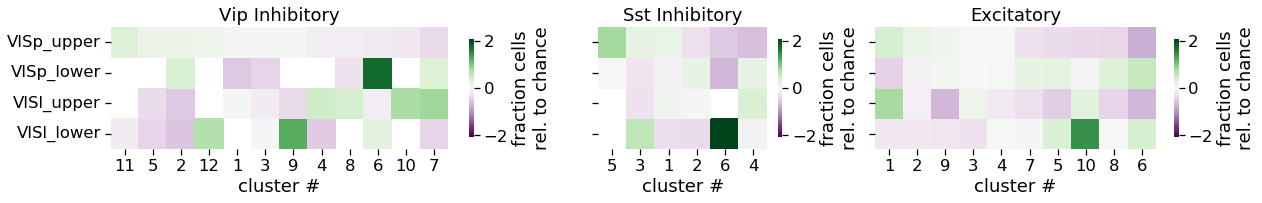

In [166]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_full_range_VISp_upper_sort'

vmax = cell_count_stats.relative_to_random.max()
vmin = cell_count_stats.relative_to_random.min()

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, 
                                                                 location='VISp_upper', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-vmax, vmax=vmax, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

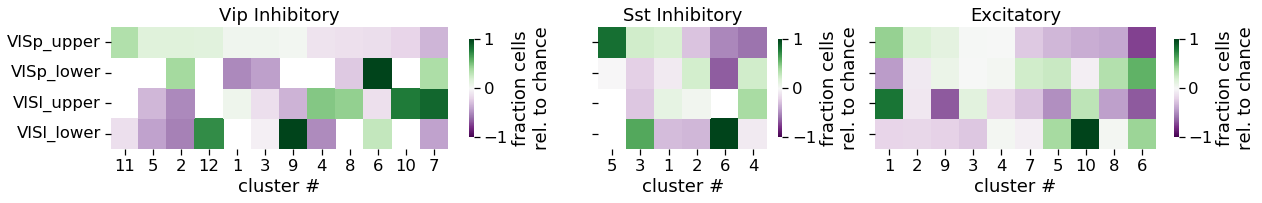

In [167]:
value_to_plot = 'relative_to_random'
cbar_label = 'fraction cells\nrel. to chance'
suffix = '_limited_range_VISp_upper_sort'

cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, 
                                                                 location='VISp_upper', metric='relative_to_random')  

plotting.plot_cell_stats_per_cluster_for_areas_depths(cluster_meta, cell_count_stats, n_clusters_cre,
                                                      value_to_plot, cbar_label, cmap='PRGn', vmin=-1, vmax=1, 
                                                      cluster_order=cluster_order, save_dir=base_dir, folder=folder, suffix=suffix)

### plot cluster heatmaps in this order

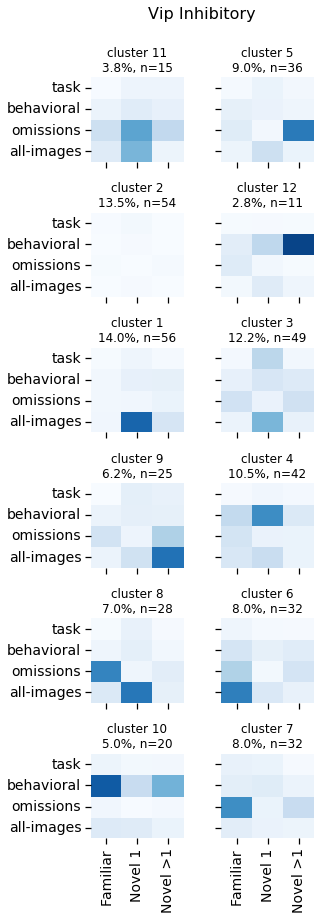

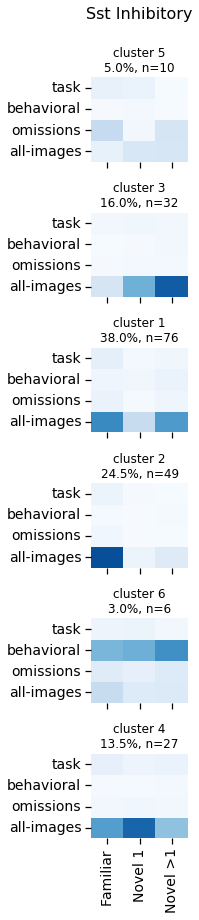

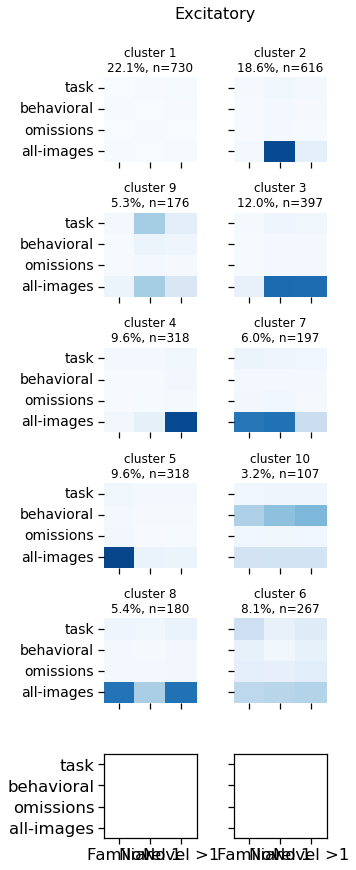

In [168]:
plotting.plot_dropout_heatmaps_for_clusters_sorted(cluster_meta, feature_matrix, cluster_order=cluster_order, 
                                       save_dir=base_dir, folder=folder, sort_type='VISp_upper_pct_rel_chance')

### test plot components then plot clusters with other information as additional panels 

### plot clusters with % cells per area and depth

In [169]:
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)
cre_fraction = fraction_cells[fraction_cells.cre_line==cre_line]

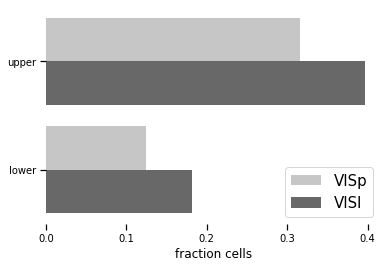

In [170]:
plotting.plot_fraction_cells_per_area_depth(cre_fraction, 1, ax=None)

### get relevant data and plot clusters with fractions

In [171]:
cell_count_stats = processing.get_cell_count_stats(cluster_meta)
cre_counts = cell_count_stats[cell_count_stats.cre_line==cre_line]

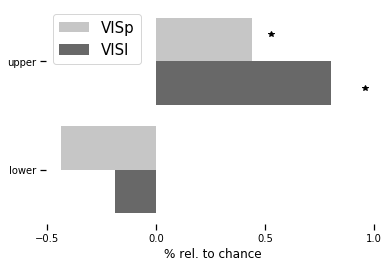

In [172]:
cluster_id = 1
plotting.plot_pct_rel_to_chance_for_cluster(cre_counts, cluster_id, ax=None)

### population average trace

In [173]:
# load dataframe with response traces
df_name = 'omission_response_df'
conditions = ['cell_specimen_id', 'omitted']

data_type = 'events'
event_type = 'omissions'
inclusion_criteria = 'active_only_closest_familiar_and_novel_containers_with_all_levels'


multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria)
print(len(multi_session_df.ophys_experiment_id.unique()))

there are 1885 experiments in the full multi_session_df
there are 1249 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  active_only_closest_familiar_and_novel_containers_with_all_levels
402


In [174]:
cluster_mdf = multi_session_df.merge(cluster_meta[['cluster_id']], 
                                     on='cell_specimen_id', how = 'inner')

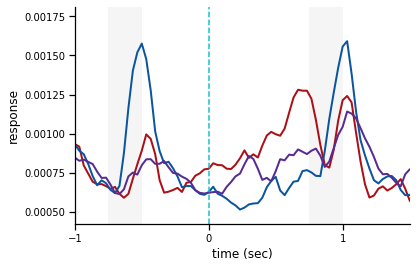

In [175]:
plotting.plot_population_average_response_for_cluster(cluster_mdf, cre_line, cluster_id, change=False, omitted=True, ax=None)

### plot clusters, fraction per area depth, and pop avgs as rows

In [176]:
# get fraction cells relative to chance per cluster per cre_line
cell_count_stats = processing.get_cell_count_stats(cluster_meta)
# get fraction of cells per area/depth per cluster per cre_line 
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)

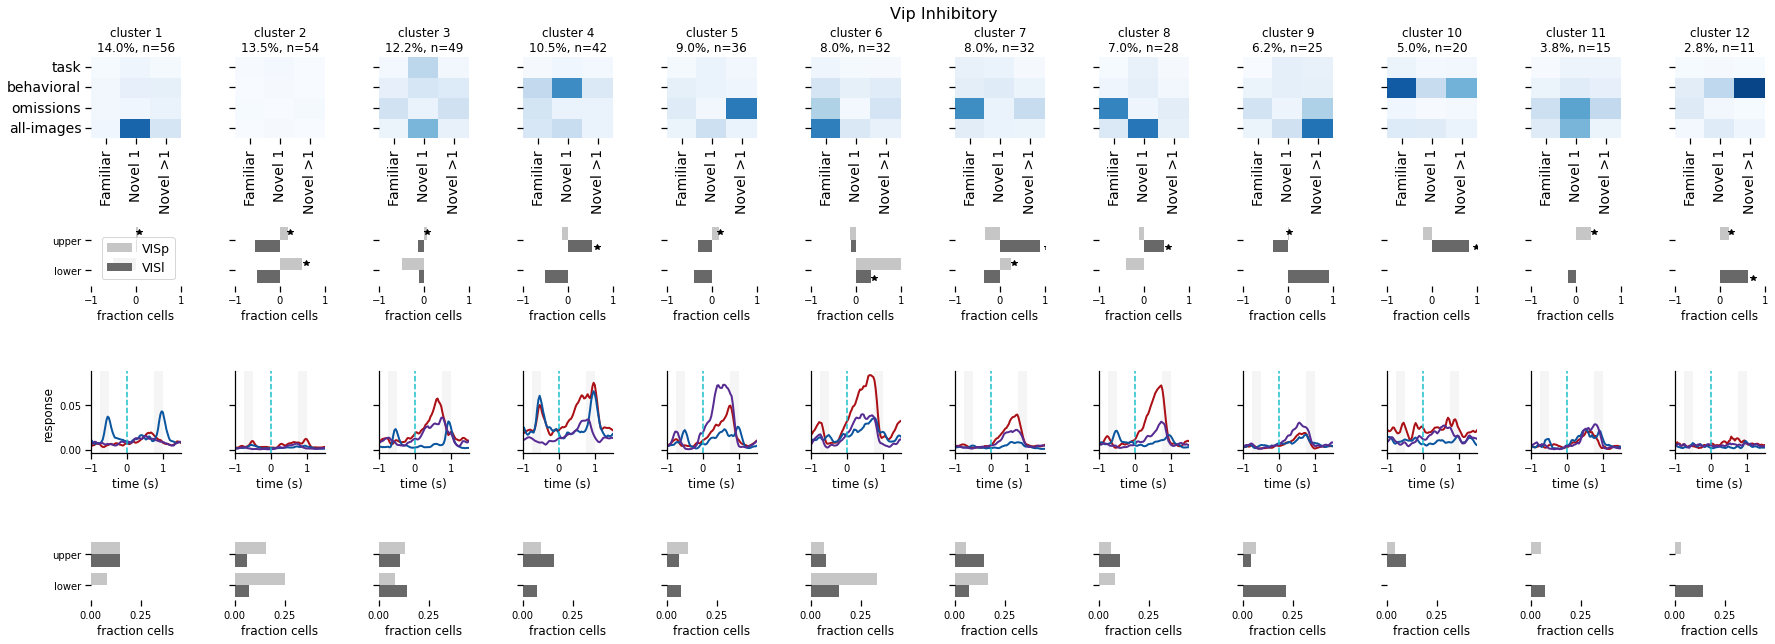

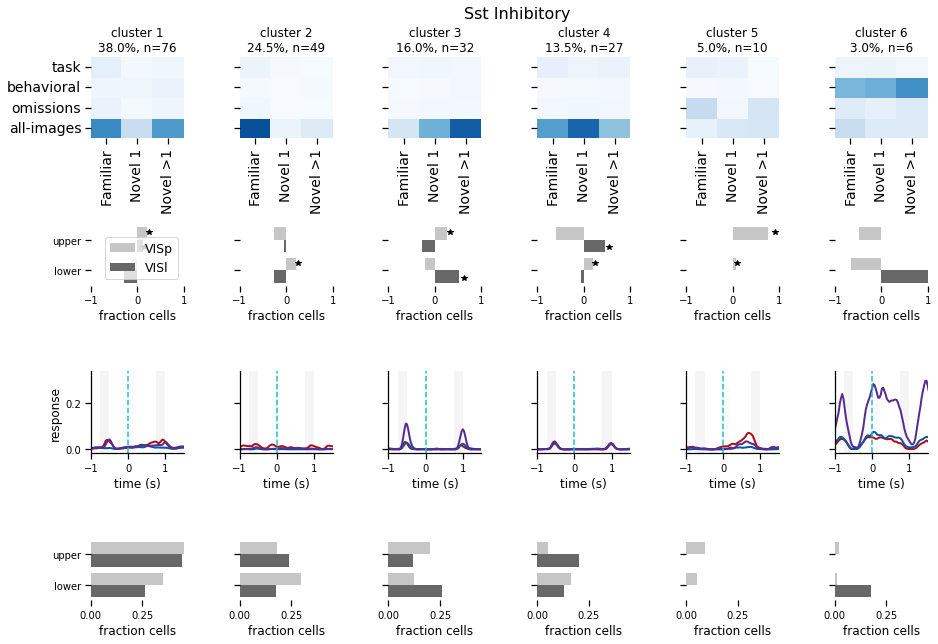

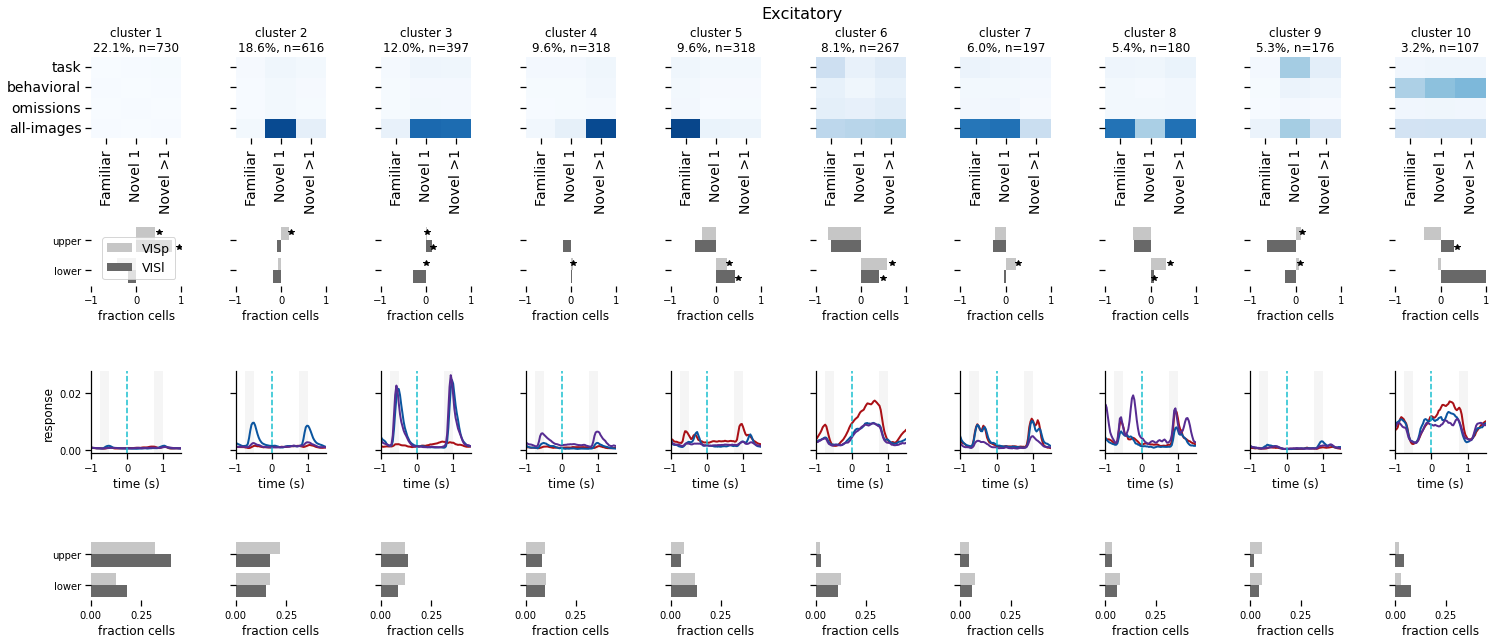

In [177]:
for cre_line in cre_lines: 
    plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
                                              cell_count_stats, fraction_cells, cre_line, 
                                              sort_order=None, suffix='_size_order', 
                                              save_dir=base_dir, folder=folder, )

### use manual sort order

In [178]:
# manual_sort_order = processing.get_manual_sort_order()

# for cre_line in cre_lines: 
#     plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
#                                               cell_count_stats, fraction_cells, cre_line, 
#                                               sort_order=manual_sort_order, suffix='_manual_sort', 
#                                               save_dir=base_dir, folder=folder, )

### sort by visp upper 

In [209]:
# get fraction cells relative to chance per cluster per cre_line
cell_count_stats = processing.get_cell_count_stats(cluster_meta)
# get fraction of cells per area/depth per cluster per cre_line 
fraction_cells = processing.get_fraction_cells_per_area_depth(cluster_meta)

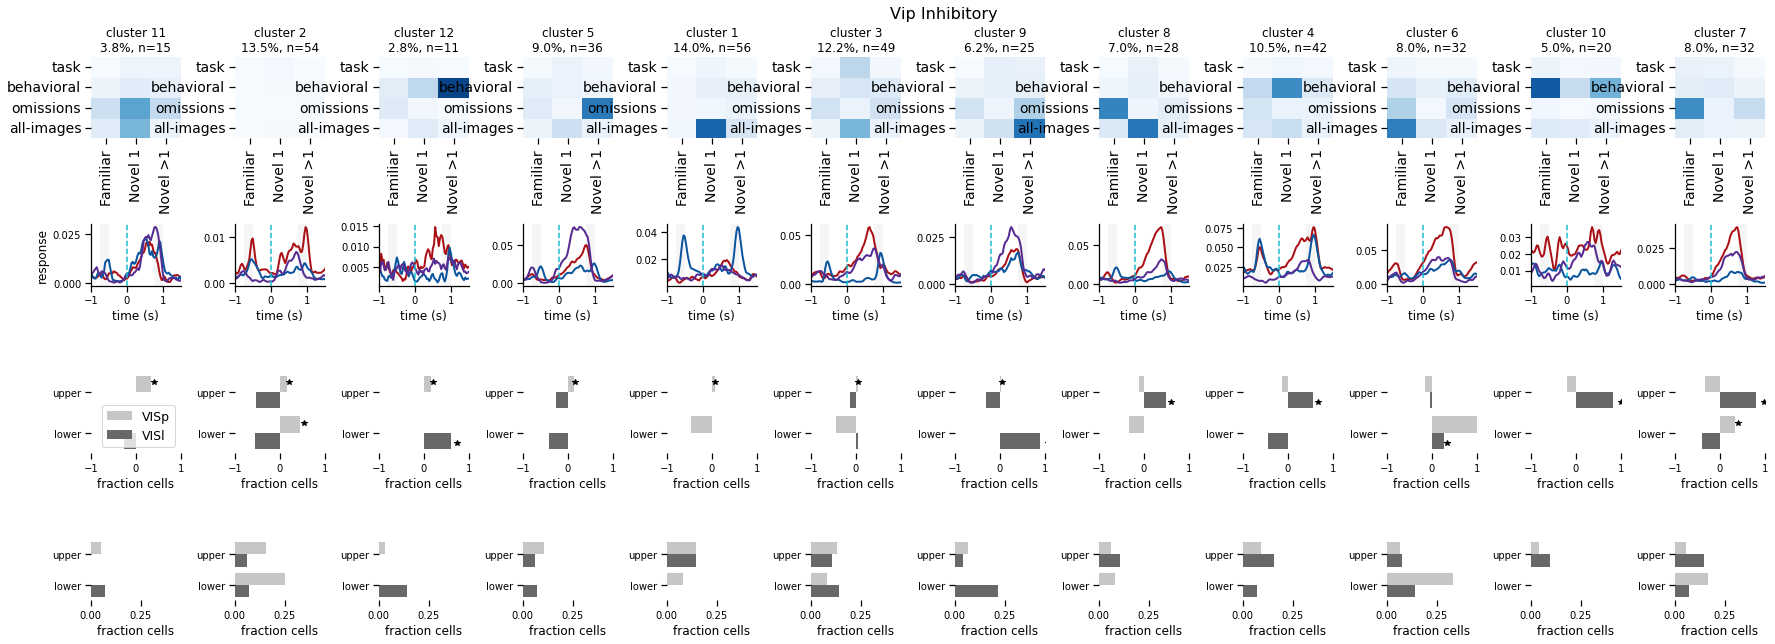

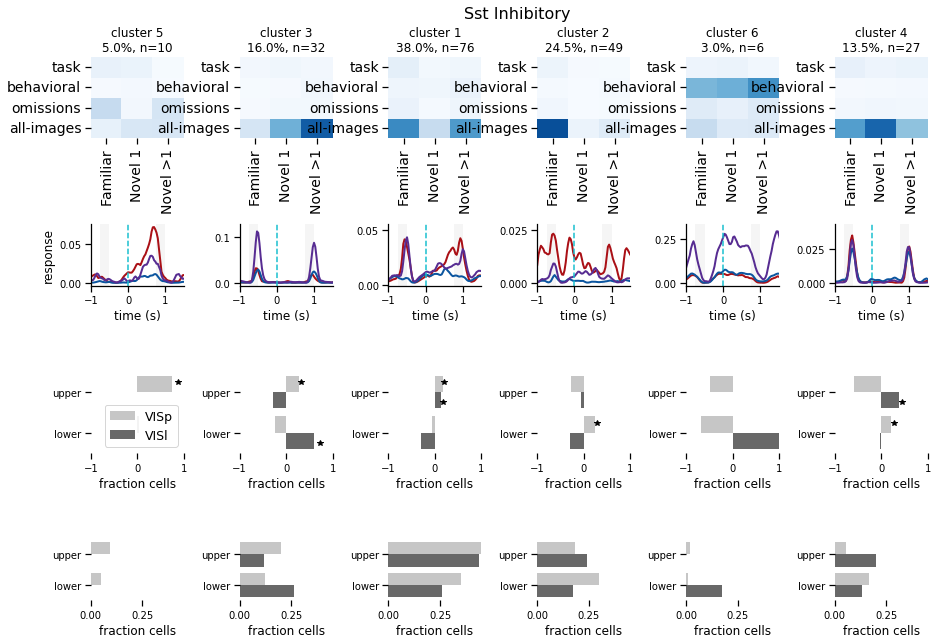

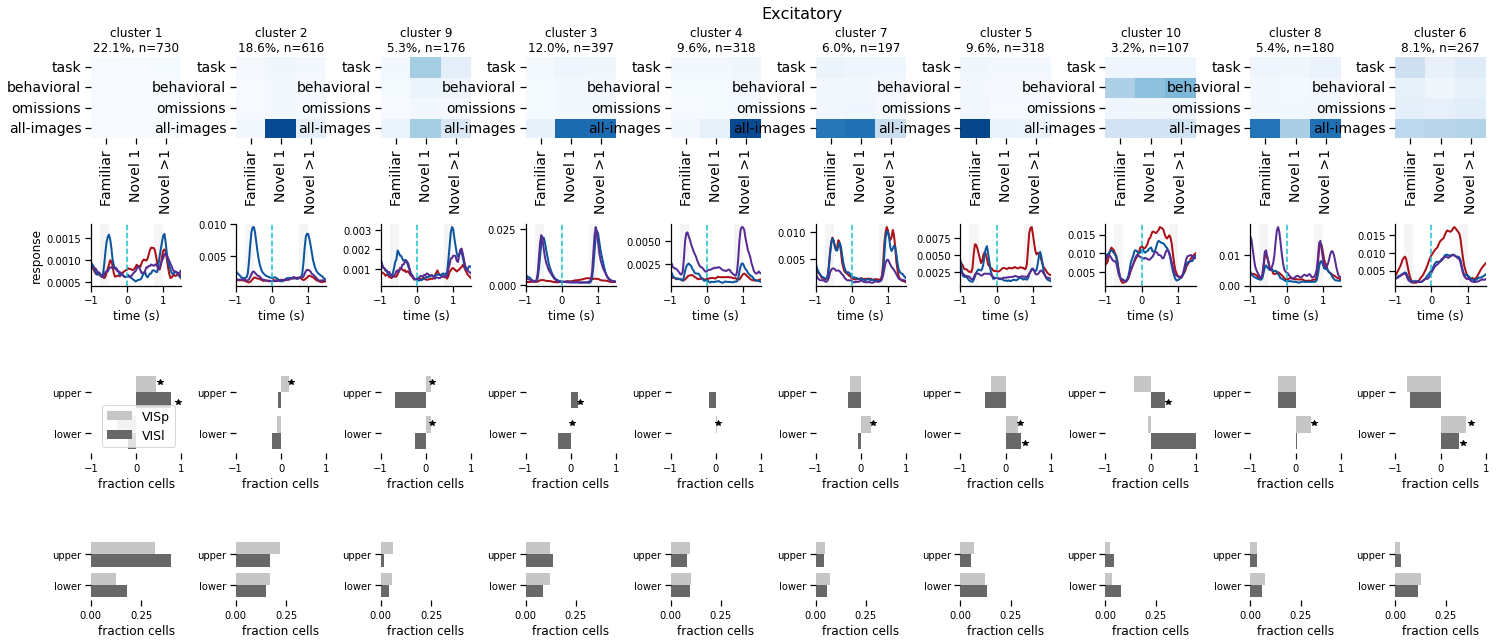

In [210]:
cell_count_stats['location'] = cell_count_stats.targeted_structure+'_'+cell_count_stats.layer
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  

for cre_line in cre_lines: 
    plotting.plot_clusters_stats_pop_avg_rows(cluster_meta, feature_matrix, multi_session_df,
                                              cell_count_stats, fraction_cells, cre_line, 
                                              sort_order=cluster_order, suffix='_VISp_upper_sort', 
                                              save_dir=base_dir, folder=folder, )

### plot as columns

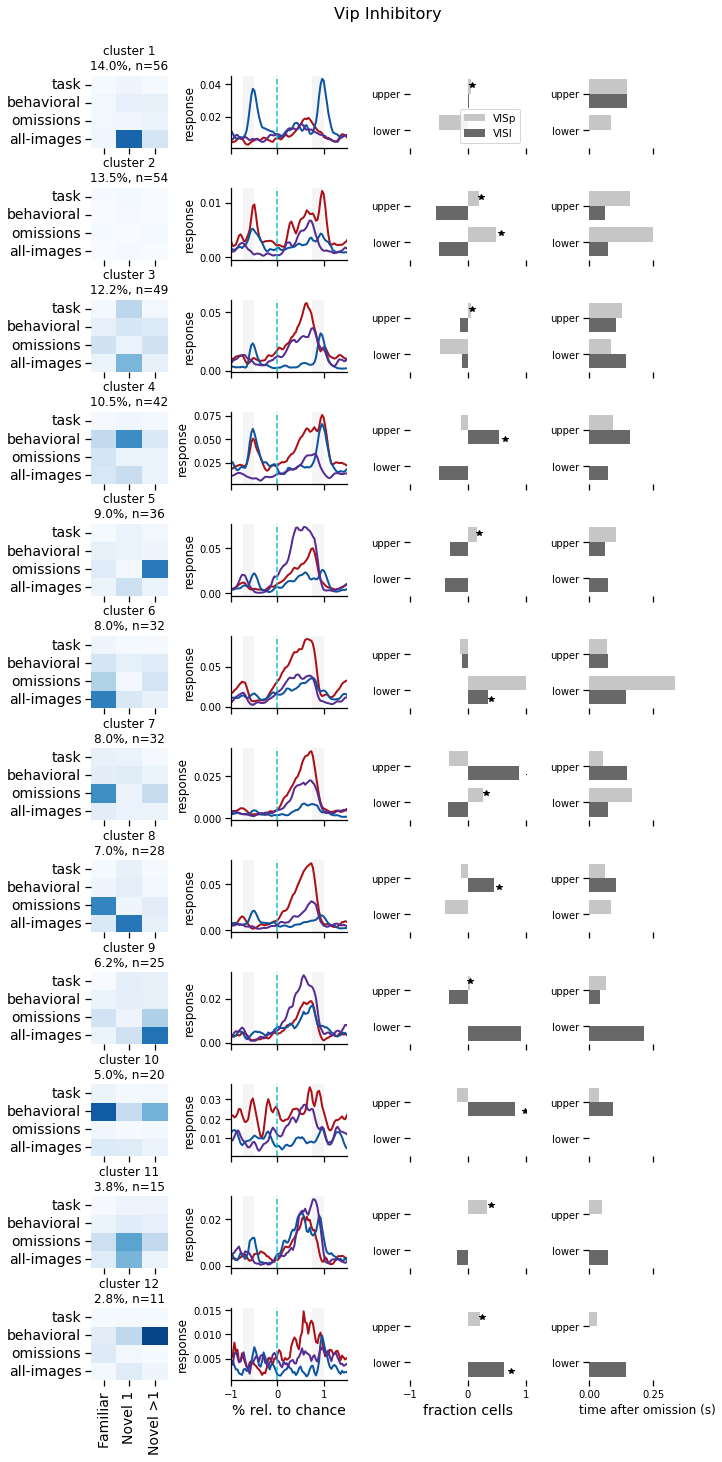

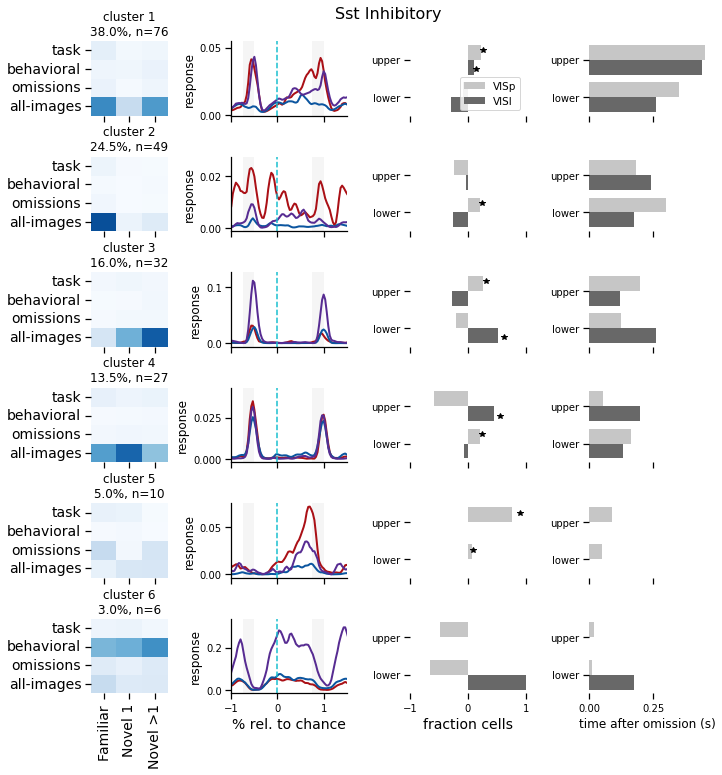

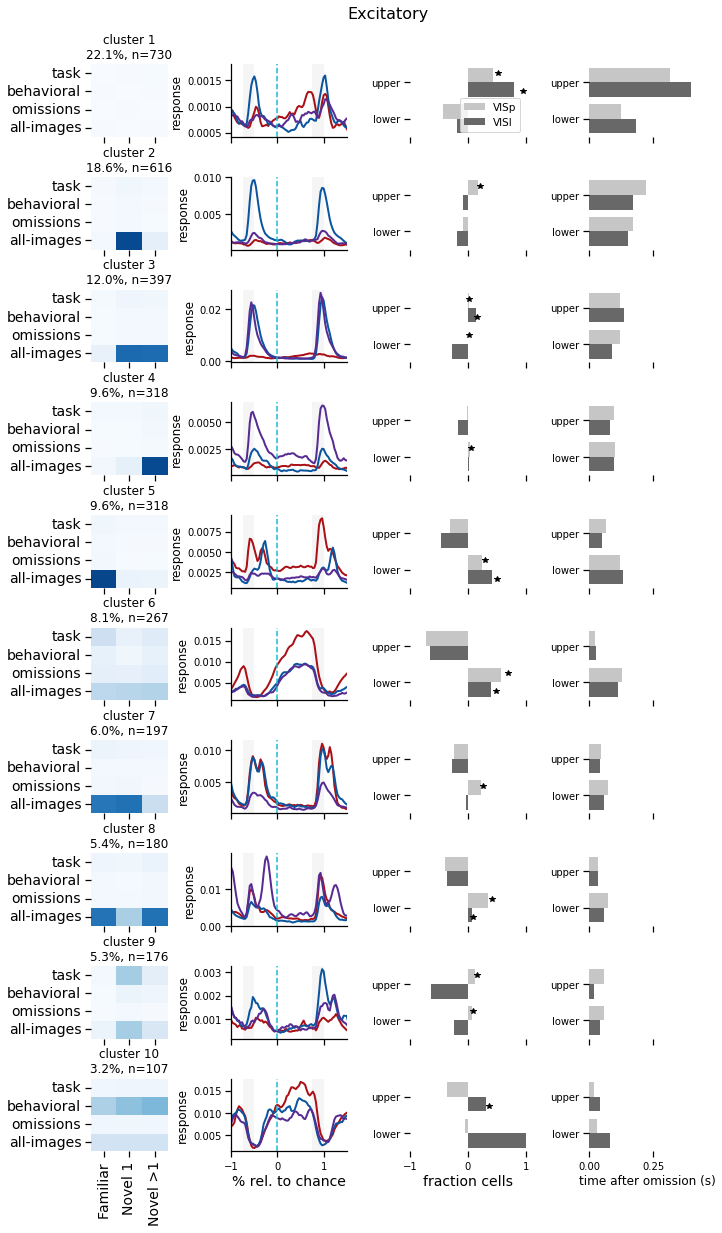

In [189]:
for cre_line in cre_lines: 
    plotting.plot_clusters_stats_pop_avg_cols(cluster_meta, feature_matrix, multi_session_df,
                                              cell_count_stats, fraction_cells, cre_line, 
                                              sort_order=cluster_order, suffix='_VISp_upper_sort', 
                                              save_dir=base_dir, folder=folder, )

### within cluster correlations sorted by VISp upper

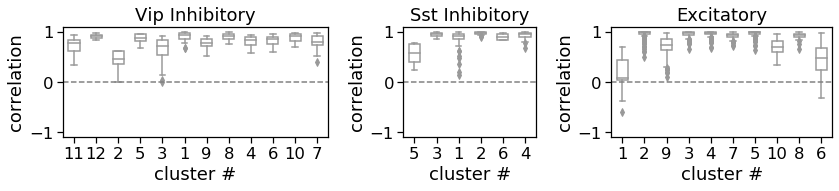

In [183]:
sort_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  

plotting.plot_within_cluster_correlations_all_cre(cluster_meta, n_clusters_cre, sort_order=sort_order, 
                                                  suffix='_VISp_upper_sort', save_dir=base_dir, folder=folder)


## Compute selectivity metrics on dropout scores

### define stats

### compute stats across cells 

* positive value of exp_mod_direction means stronger coding of pref feature in novel session 
* positive value of exp_mod_persistence means similar coding in Novel 1 and Novel >1 for pref feature
* high value of feature_sel_within_session means highly feature selective in strongest exp level
* low value of feature_sel_within_session means similar strength of coding for multiple features in a given session
* high value of feature_sel_across sessions means there is a big difference between the strength of coding for the preferred feature in the preferred experience level and a different feature in a different experience level 
* low value of feature_sel_across sessions means similar coding across two different features in two different sessions
* cell switching is indicated by low feature_sel_across_sessions and high experience selectivity
* lack of coding overall would be low exp selectivity and low feature_sel_across_sessions

In [194]:
dropouts = dropouts.reset_index()

In [195]:
cell_stats = pd.DataFrame()
for i, cell_specimen_id in enumerate(cluster_meta.index.values):
    cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
    stats = processing.get_coding_metrics(index_dropouts=cell_dropouts, index_value=cell_specimen_id, index_name='cell_specimen_id')
    cell_stats = pd.concat([cell_stats, stats], sort=False)
cell_stats = cell_stats.merge(cluster_meta, on='cell_specimen_id')
metrics = stats.keys()[-6:]

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:926: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:929: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:929: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:916: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\processing.py:920: RuntimeWarning:

invalid value encountered in double_scalars

c:\users\marinag\documents\code\visual_behavior_a

### average stats across cells per cluster

In [196]:
avg_cluster_stats = cell_stats.groupby(['cre_line', 'cluster_id']).mean()
avg_cluster_stats = avg_cluster_stats[list(metrics)]
avg_cluster_stats = avg_cluster_stats.reset_index()
n_cells = cell_stats.groupby(['cre_line', 'cluster_id']).count()[['labels']].rename(columns={'labels':'n_cells'})
avg_cluster_stats = avg_cluster_stats.merge(n_cells, on=['cre_line', 'cluster_id'])

### compute stats on each cluster directly

In [197]:
cluster_stats = pd.DataFrame()
for cre_line in cre_lines:
    # get cell specimen ids for this cre line
    cre_cell_specimen_ids = cluster_meta[cluster_meta.cre_line==cre_line].index.values
    # get cluster labels dataframe for this cre line
    cre_cluster_ids = cluster_meta.loc[cre_cell_specimen_ids]
    # get unique cluster labels for this cre line
    cluster_labels = np.sort(cre_cluster_ids.cluster_id.unique())
    # limit dropouts df to cells in this cre line
    feature_matrix_cre = feature_matrix.loc[cre_cell_specimen_ids]
    for i, cluster_id in enumerate(cluster_labels):
        # get cell specimen ids in this cluster in this cre line
        this_cluster_csids = cre_cluster_ids[cre_cluster_ids['cluster_id'] == cluster_id].index.values
        # get dropout scores for cells in this cluster in this cre line
        mean_dropout_df = np.abs(feature_matrix_cre.loc[this_cluster_csids].mean().unstack())
        stats = processing.get_coding_metrics(index_dropouts=mean_dropout_df.T, index_value=cluster_id, index_name='cluster_id')
        fraction_cre = len(this_cluster_csids) / float(len(cre_cell_specimen_ids))
        stats['fraction_cre'] = fraction_cre
        stats['cre_line'] = cre_line
        stats['F_max'] = mean_dropout_df['Familiar'].max()
        stats['N1_max'] = mean_dropout_df['Novel 1'].max()
        stats['N2_max'] = mean_dropout_df['Novel >1'].max()
        cluster_stats = pd.concat([cluster_stats, stats])
cluster_stats = cluster_stats.reset_index()
n_cells = cell_stats.groupby(['cre_line', 'cluster_id']).count()[['labels']].rename(columns={'labels':'n_cells_cluster'})
cluster_stats = cluster_stats.merge(n_cells, on=['cre_line', 'cluster_id'])

### merge cluster stats with cell counts per cluster

In [198]:
# create location column merging area and depth
cell_count_stats['location'] = cell_count_stats.targeted_structure+'_'+cell_count_stats.layer
# group & unstack to get fraction relative to random for each location as columns
fraction_cells = cell_count_stats[['cre_line', 'cluster_id', 'location', 'relative_to_random']].groupby(['cre_line', 'cluster_id', 'location']).mean().unstack()
# get rid of multi-index column
fraction_cells.columns = fraction_cells.columns.droplevel()
# merge fraction cells per location with other cluster metrics
cluster_stats = fraction_cells.reset_index().merge(cluster_stats, on=['cre_line', 'cluster_id'])

In [199]:
cluster_stats.head()

,cre_line,cluster_id,VISl_lower,VISl_upper,VISp_lower,VISp_upper,dominant_feature,dominant_experience_level,next_highest_conditions,feature_selectivity,experience_selectivity,exp_mod_direction,exp_mod_persistence,feature_sel_within_session,feature_sel_across_sessions,fraction_cre,F_max,N1_max,N2_max,n_cells_cluster
0,Slc17a7-IRES2-Cre,1,-0.184228,0.797069,-0.432092,0.427123,task,Novel >1,"(Familiar, all-images)",0.259593,0.401007,0.358913,1.721184,0.196154,0.161622,0.220811,0.006164,0.004962,0.008541,730
1,Slc17a7-IRES2-Cre,2,-0.181167,-0.086311,-0.078233,0.180609,all-images,Novel 1,"(Novel >1, task)",0.932991,0.876952,0.942771,0.101657,0.908842,0.943787,0.186328,0.026490,0.899264,0.091417,616
2,Slc17a7-IRES2-Cre,3,-0.278771,0.136651,0.009365,0.012601,all-images,Novel 1,"(Novel >1, task)",0.923989,0.297619,0.820990,0.984265,0.892202,0.902111,0.120085,0.076725,0.780486,0.768205,397
3,Slc17a7-IRES2-Cre,4,0.015228,-0.166132,0.037182,-0.008433,all-images,Novel >1,"(Novel 1, task)",0.937595,0.873003,0.468151,10.045562,0.916188,0.954869,0.096189,0.032399,0.089438,0.898452,318
4,Slc17a7-IRES2-Cre,5,0.416431,-0.467419,0.246046,-0.314425,all-images,Familiar,"(Novel >1, task)",0.934515,0.873936,-0.864767,0.855276,0.915658,0.945945,0.096189,0.914823,0.066343,0.056741,318


### plot each relationship on its own fig

In [200]:
# for col_x in cluster_stats.columns[2:]:
#     for col_y in cluster_stats.columns[2:]:
#         try:
#             figsize=(4,4)
#             fig, ax = plt.subplots(figsize=figsize)
#             ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
#                                 hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
#             ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
#             ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
#             ax.get_legend().remove()
#             plt.axis("equal")
#             for i in range(len(cluster_stats[col_x].values)):
#                 xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#                 color_index = cluster_stats['color_index'].values[i]
#                 cluster_id = cluster_stats['cluster_id'].values[i]
#                 plt.annotate(cluster_id, xy, color=colors[color_index])
#             utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)
#         except:
#             pass

### barplots of metric values for clusters

problem for next_highest_conditions


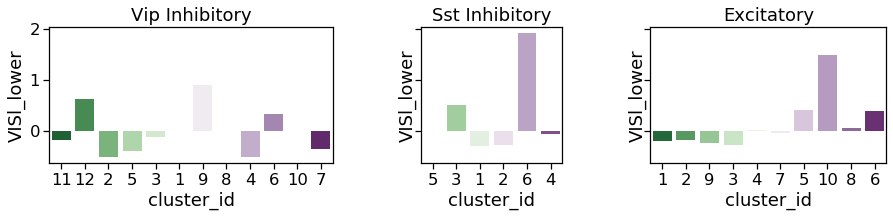

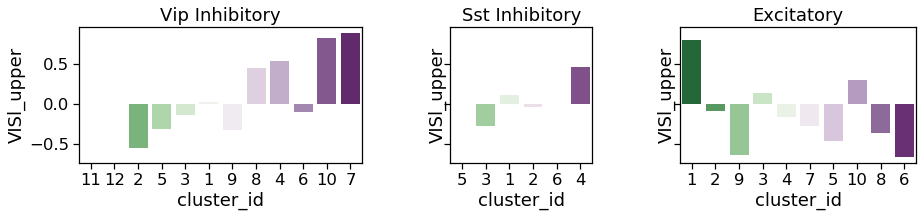

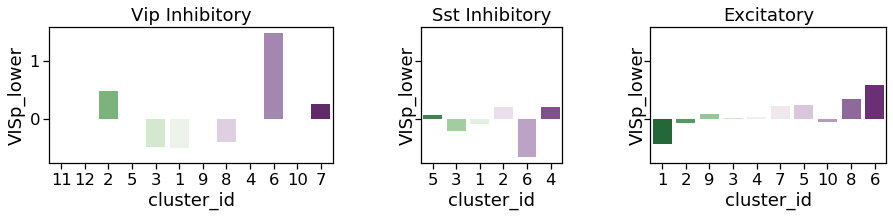

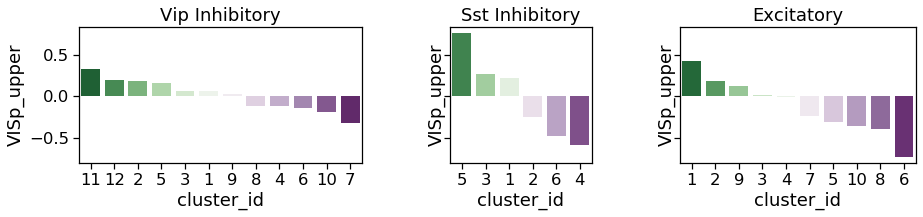

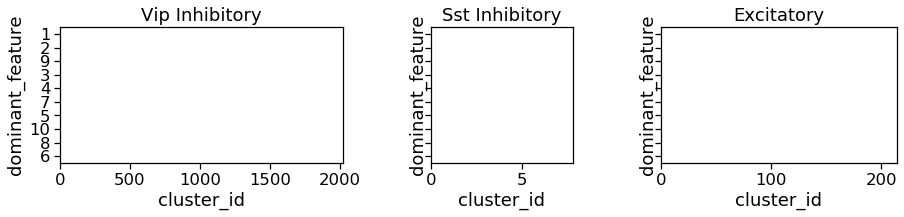

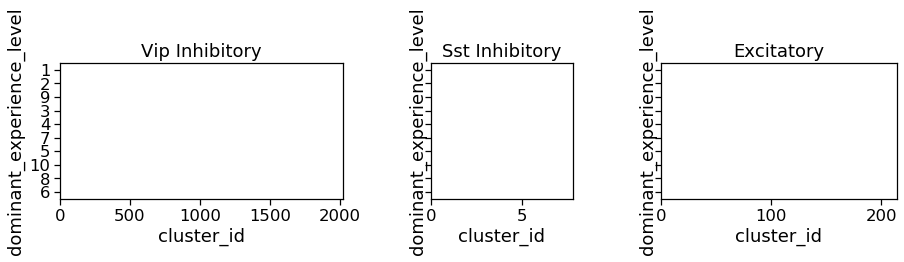

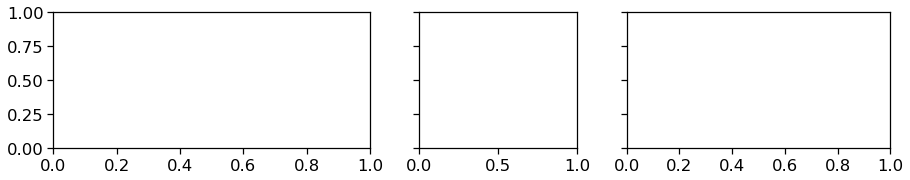

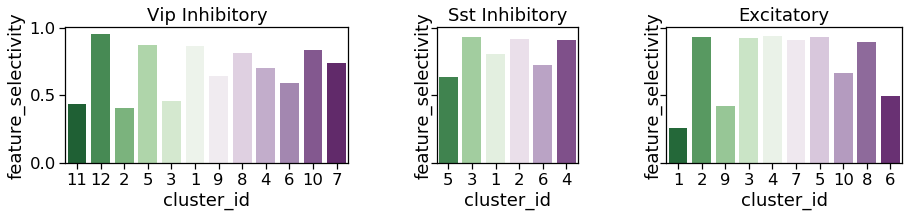

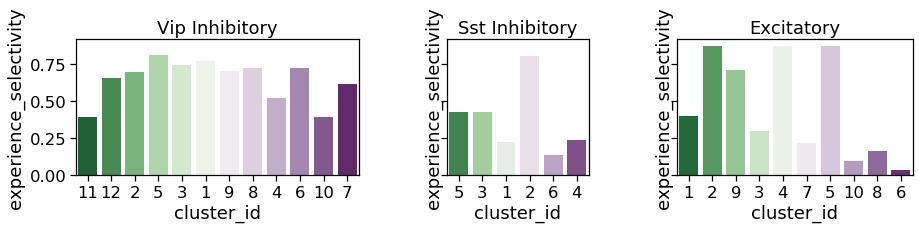

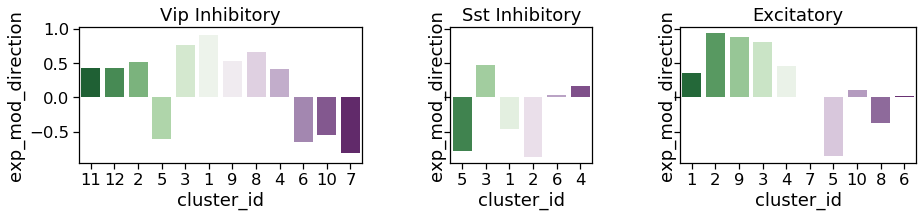

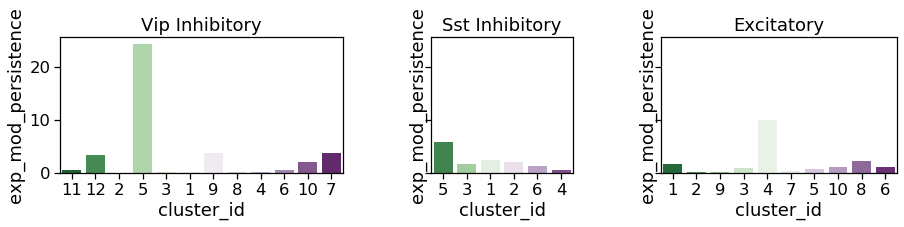

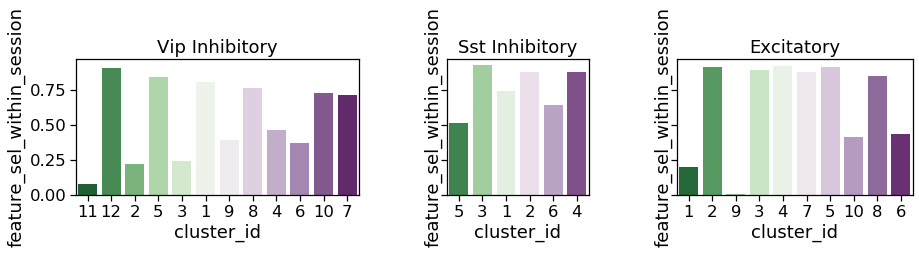

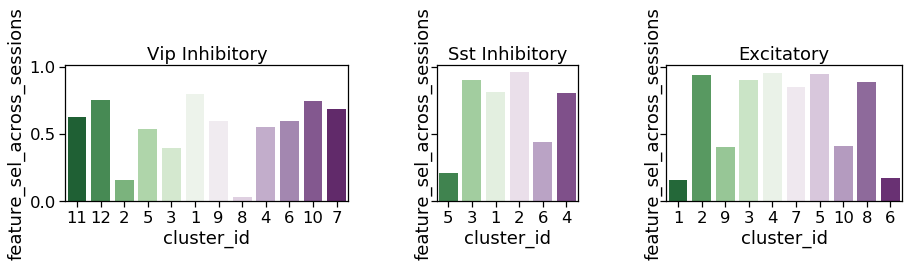

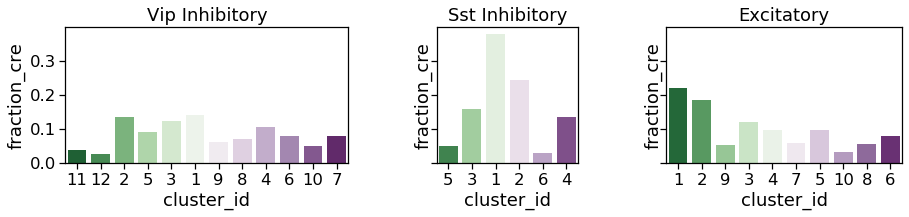

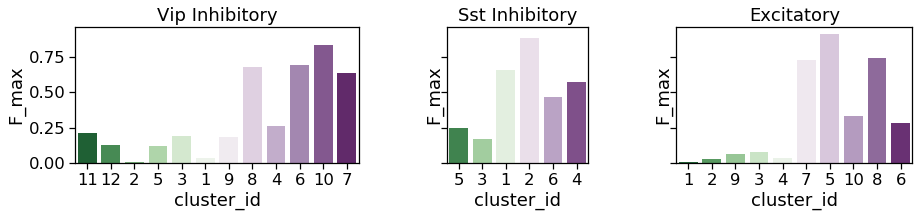

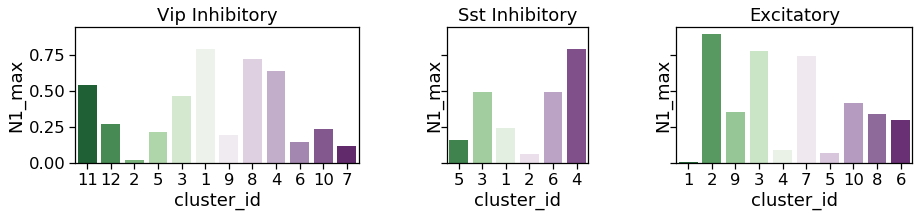

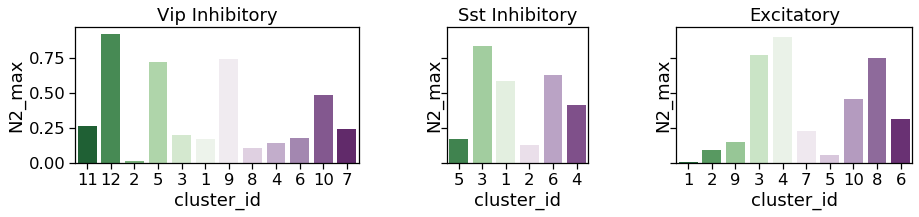

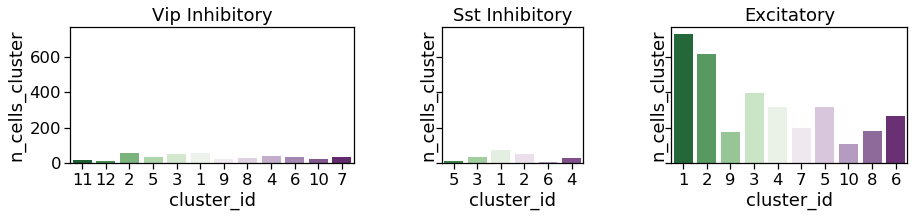

In [201]:
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  
n_clusters = [n_clusters_cre[cre] for cre in cre_lines]

for metric in cluster_stats.columns[2:]:
    try:
        figsize=(15,2.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters}, sharey=True)
        for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
            data = cluster_stats[cluster_stats.cre_line==cre_line]
            ax[i] = sns.barplot(data=data, x='cluster_id', order=cluster_order[cre_line], y=metric, 
                                hue='VISp_upper', palette='PRGn', ax=ax[i], dodge=False)
            ax[i].set_title(processing.get_cell_type_for_cre_line(cluster_meta, cre_line))
            ax[i].get_legend().remove()
        plt.subplots_adjust(wspace=0.4)
        utils.save_figure(fig, figsize, save_dir, 'pointplots_VISp_upper_sort', metric)
    except:
        print('problem for', metric)

### relationship of across session switching and Familiar session max to % cells in VISp or VISl

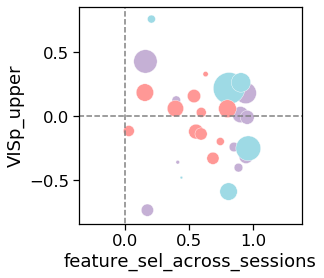

In [202]:
col_x = 'feature_sel_across_sessions'
col_y = 'VISp_upper'

colors = utils.get_cre_line_colors()

figsize=(4,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
                    hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
ax.get_legend().remove()
plt.axis("equal")
# for i in range(len(cluster_stats[col_x].values)):
#     xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#     color_index = cluster_stats['color_index'].values[i]
#     cluster_id = cluster_stats['cluster_id'].values[i]
#     plt.annotate(cluster_id, xy, color=colors[color_index])
utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)


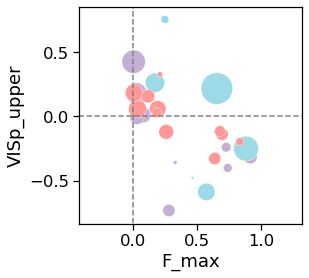

In [203]:
col_x = 'F_max'
col_y = 'VISp_upper'

colors = utils.get_cre_line_colors()

figsize=(4,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
                    hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
ax.get_legend().remove()
plt.axis("equal")
# for i in range(len(cluster_stats[col_x].values)):
#     xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#     color_index = cluster_stats['color_index'].values[i]
#     cluster_id = cluster_stats['cluster_id'].values[i]
#     plt.annotate(cluster_id, xy, color=colors[color_index])
utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)


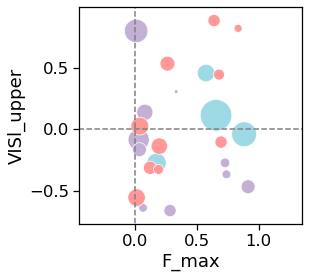

In [204]:
col_x = 'F_max'
col_y = 'VISl_upper'

colors = utils.get_cre_line_colors()

figsize=(4,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=cluster_stats, x=col_x, y=col_y, size='fraction_cre', sizes=(0, 1000), 
                    hue='cre_line', hue_order=cre_lines, palette=colors, ax=ax)
ax.axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
ax.axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
ax.get_legend().remove()
plt.axis("equal")
# for i in range(len(cluster_stats[col_x].values)):
#     xy = (cluster_stats[col_x].values[i], cluster_stats[col_y].values[i])
#     color_index = cluster_stats['color_index'].values[i]
#     cluster_id = cluster_stats['cluster_id'].values[i]
#     plt.annotate(cluster_id, xy, color=colors[color_index])
utils.save_figure(fig, figsize, save_dir, 'scatterplots', col_x+'_'+col_y)


### boxplots of metric values for all cells in each cluster

#### first merge with fraction cells info per cluster

In [205]:
# create location column merging area and depth
cell_count_stats['location'] = cell_count_stats.targeted_structure+'_'+cell_count_stats.layer
# group & unstack to get fraction relative to random for each location as columns
fraction_cells = cell_count_stats[['cre_line', 'cluster_id', 'location', 'relative_to_random']].groupby(['cre_line', 'cluster_id', 'location']).mean().unstack()
# get rid of multi-index column
fraction_cells.columns = fraction_cells.columns.droplevel()
# merge fraction cells per location with other cluster metrics
cell_stats_loc = fraction_cells.reset_index().merge(cell_stats.reset_index(), on=['cre_line', 'cluster_id'])
cell_stats_loc = cell_stats_loc.set_index('cell_specimen_id')

problem for next_highest_conditions


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1236: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning:

invalid value encountered in multiply

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\matplotlib\cbook\__init__.py:1236: RuntimeWarning:

invalid value encountered in double_scalars



problem for fraction_cre
problem for F_max
problem for N1_max
problem for N2_max
problem for n_cells_cluster


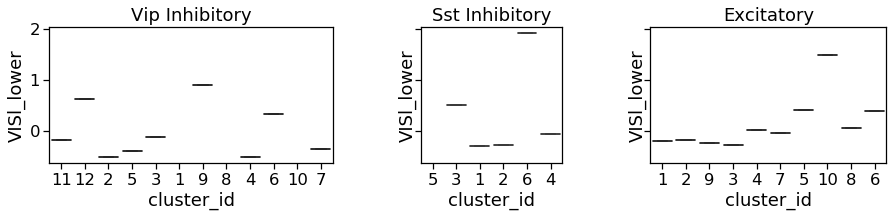

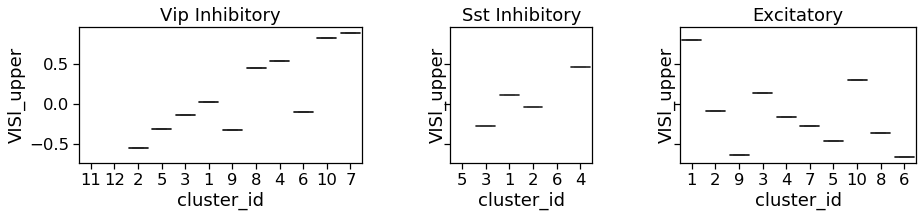

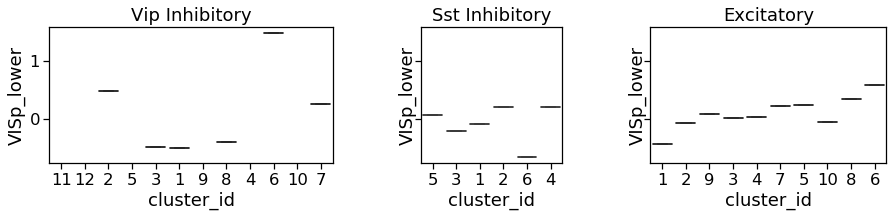

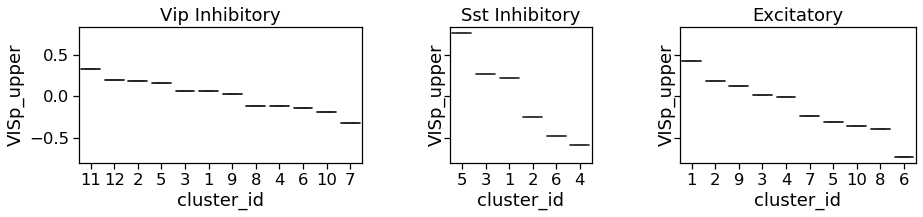

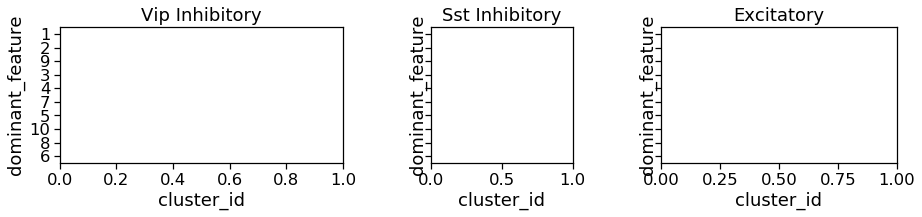

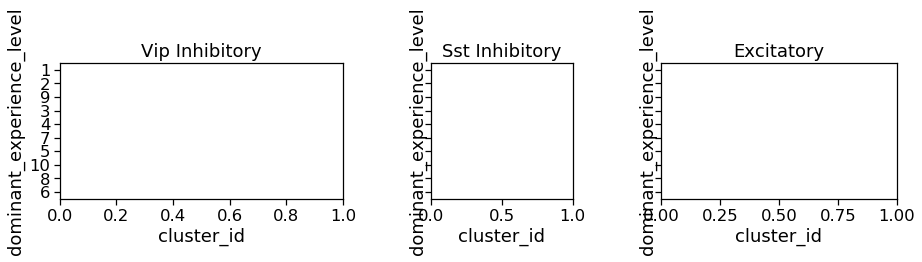

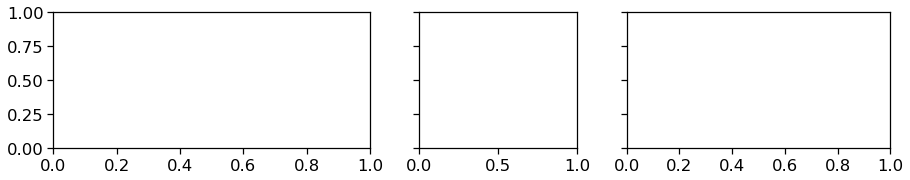

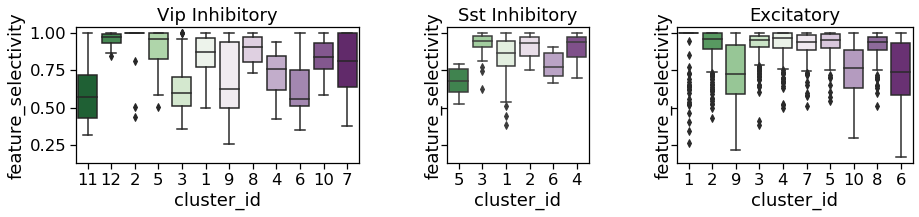

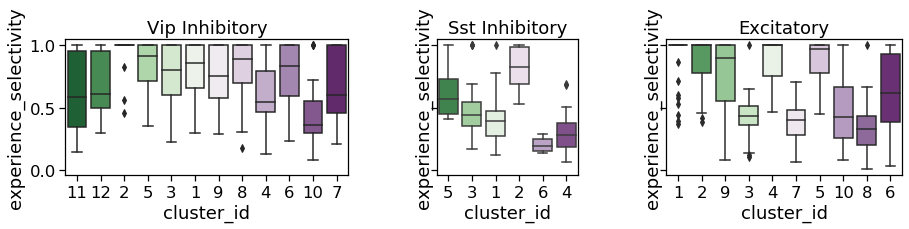

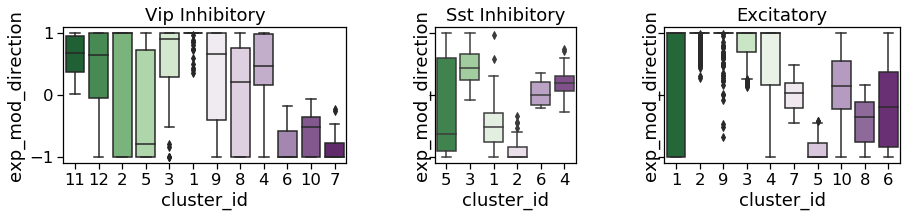

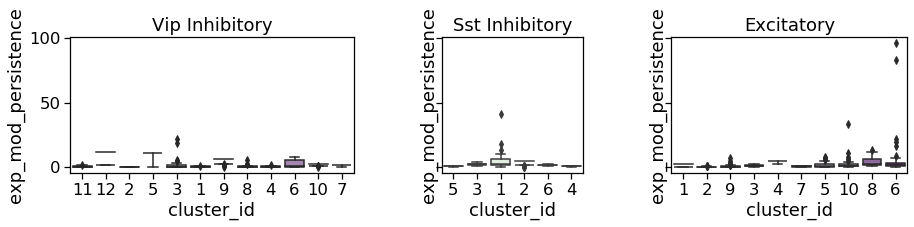

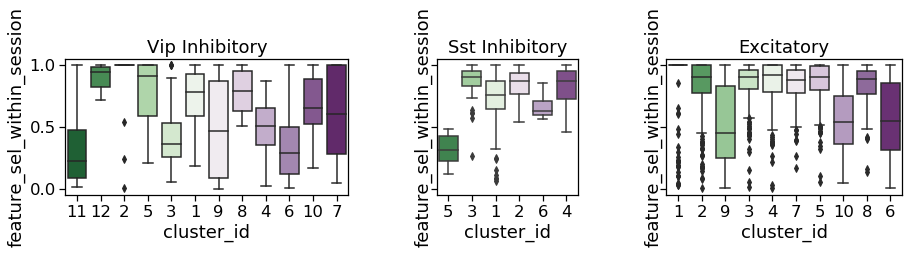

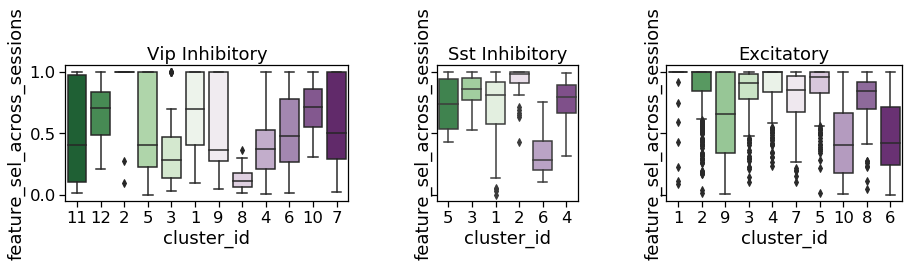

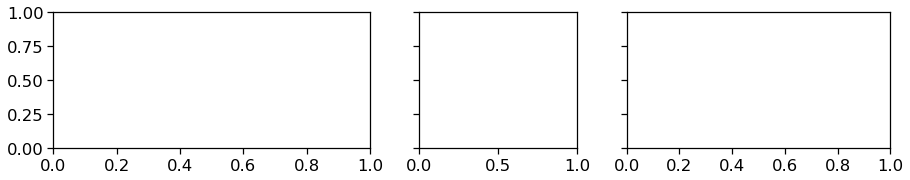

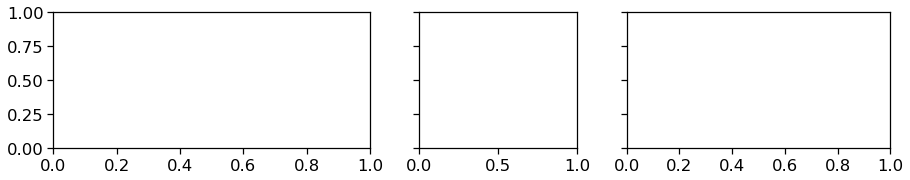

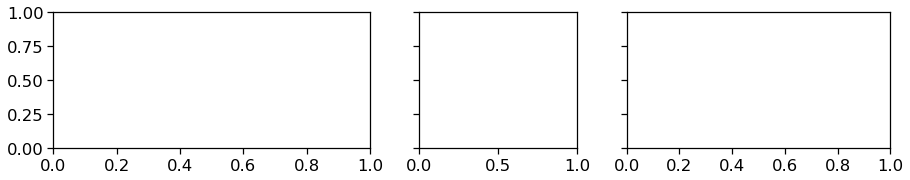

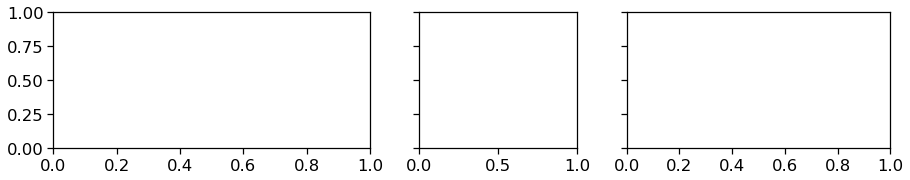

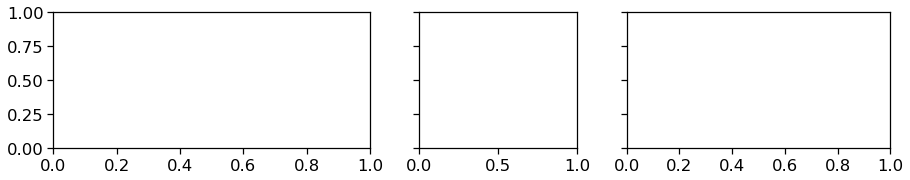

In [207]:
cluster_order = processing.get_cluster_order_for_metric_location(cell_count_stats, cluster_meta, location='VISp_upper', metric='relative_to_random')  
n_clusters = [n_clusters_cre[cre] for cre in cre_lines]

for metric in cluster_stats.columns[2:]:
    try:
        figsize=(15,2.5)
        fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios':n_clusters}, sharey=True)
        for i, cre_line in enumerate(processing.get_cre_lines(cluster_meta)):
            data = cell_stats_loc[cell_stats_loc.cre_line==cre_line]
            ax[i] = sns.boxplot(data=data, x='cluster_id', order=cluster_order[cre_line], y=metric, 
                                hue='VISp_upper', palette='PRGn', ax=ax[i], dodge=False)
            ax[i].set_title(processing.get_cell_type_for_cre_line(cluster_meta, cre_line))
            ax[i].get_legend().remove()
        plt.subplots_adjust(wspace=0.4)
        utils.save_figure(fig, figsize, save_dir, 'boxplots_VISp_upper_sort', metric)
    except:
        print('problem for', metric)

## Summary plots experimentation

### plot experience mod values for cluster average

In [ ]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
# utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_avg_across_cells_in_cluster')

### cells and clusters together 

In [ ]:
figsize = (15,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = cell_stats[cell_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', alpha=0.2,
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    ax[i] = sns.scatterplot(data=data, x='exp_mod_direction', y='exp_mod_persistence', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i], alpha=0.7)
    
    ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
    ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line]+'\n experience modulation')
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('persistence')
    ax[i].set_xlim(-1.2,1.2)
    ax[i].set_ylim(-1.2,1.2)
fig.tight_layout()
# utils.save_figure(fig, figsize, base_dir, folder, 'experience_modulation_across_cells_and_clusters')

### feature selectivity within and across sesions

In [ ]:
# figsize = (15,5)
# fig, ax = plt.subplots(1,3, figsize=figsize)
# for i, cre_line in enumerate(cre_lines):
#     data = cell_stats[cell_stats.cre_line==cre_line]
#     data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
#     cluster_order = np.sort(data.cluster_id.unique())
#     n_clusters = len(cluster_order)
#     ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', alpha=0.2,
#                             hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], ax=ax[i])
    
#     data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
#     data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
#     cluster_order = np.sort(data.cluster_id.unique())
#     n_clusters = len(cluster_order)
#     ax[i] = sns.scatterplot(data=data, x='feature_sel_within_session', y='feature_sel_across_sessions', 
#                             hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
#                             size='n_cells', sizes=(0, 1000), ax=ax[i], alpha=0.7)
    
# #     ax[i].axvline(x=0, ymin=0, ymax=1, linestyle='--', color='gray')
# #     ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
#     ax[i].set_title(cell_types[cre_line]+'\n feature selectivity')
#     ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
#     ax[i].set_xlabel('within session')
#     ax[i].set_ylabel('across sessions')
#     ax[i].set_xlim(-0.1,1.1)
#     ax[i].set_ylim(-0.1,1.1)
# fig.tight_layout()
# # utils.save_figure(fig, figsize, base_dir, folder, 'feature_selectivity_across_cells_and_clusters')

### feature selectivity across sessions vs. experience selectivity 

* cell switching is indicated by low feature_sel_across_sessions and high experience selectivity


In [ ]:
figsize = (17,5)
fig, ax = plt.subplots(1,3, figsize=figsize)
for i, cre_line in enumerate(cre_lines):
    data = avg_cluster_stats[avg_cluster_stats.cre_line==cre_line]
    data = data[data.cluster_id<10] # TEMPORARY to make sure we dont exceed # clusters in palette
    cluster_order = np.sort(data.cluster_id.unique())
    n_clusters = len(cluster_order)
    print(n_clusters)
    ax[i] = sns.scatterplot(data=data, x='experience_selectivity', y='feature_sel_across_sessions', 
                            hue='cluster_id', hue_order=cluster_order, palette=sns.color_palette()[:n_clusters], 
                            size='n_cells', sizes=(0, 1000), ax=ax[i])
#     ax[i].axvline(x=0, ymin=-1, ymax=1, linestyle='--', color='gray')
#     ax[i].axhline(y=0, xmin=-1, xmax=1, linestyle='--', color='gray')
    ax[i].set_title(cell_types[cre_line])
    ax[i].legend(fontsize='small', title_fontsize='small', bbox_to_anchor=(1,1))
    ax[i].set_xlabel('experience modulation')
    ax[i].set_ylabel('feature selectivity across sessions')
    ax[i].set_xlim(0, 1.1)
    ax[i].set_ylim(0, 1.1)
fig.tight_layout()
# utils.save_figure(fig, figsize, base_dir, folder, 'feature_sel_exp_mod_avg_across_cells_in_cluster')

### summarize

In [ ]:
n_clusters_per_cre = cell_stats.groupby(['cre_line']).count().rename(columns={'cluster_id':'n_cells_total'})[['n_cells_total']]
n_clusters_per_feature = cell_stats.groupby(['cre_line', 'dominant_feature']).count().rename(columns={'cluster_id':'n_cells'})[['n_cells']]
n_clusters_per_feature = n_clusters_per_feature.reset_index().merge(n_clusters_per_cre, on='cre_line')
n_clusters_per_feature['fraction_cells'] = n_clusters_per_feature['n_cells']/n_clusters_per_feature['n_cells_total']

In [ ]:
colors = utils.get_cre_line_colors()[::-1]

figsize=(4.5,3)
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=n_clusters_per_feature, x='dominant_feature', y='fraction_cells', hue='cre_line',
             palette=colors, order=features, hue_order=cre_lines, ax=ax)
ax.legend(fontsize='xx-small', title='', loc='upper right')
ax.set_ylabel('fraction of cells')
ax.set_xlabel('')
ax.set_title('feature preference')
ax.set_xticklabels(features, rotation=45)

In [ ]:
n_clusters_per_cre = cell_stats.groupby(['cre_line']).count().rename(columns={'cluster_id':'n_cells_total'})[['n_cells_total']]
n_clusters_per_feature = cell_stats.groupby(['cre_line', 'dominant_experience_level']).count().rename(columns={'cluster_id':'n_cells'})[['n_cells']]
n_clusters_per_feature = n_clusters_per_feature.reset_index().merge(n_clusters_per_cre, on='cre_line')
n_clusters_per_feature['fraction_cells'] = n_clusters_per_feature['n_cells']/n_clusters_per_feature['n_cells_total']

In [ ]:
colors = utils.get_cre_line_colors()[::-1]
experience_levels = np.sort(cluster_meta.experience_level.unique())

figsize=(4.5,3)
fig, ax = plt.subplots(figsize=figsize)
sns.barplot(data=n_clusters_per_feature, x='dominant_experience_level', y='fraction_cells', hue='cre_line',
             palette=colors, order=experience_levels, hue_order=cre_lines, ax=ax)
ax.legend(fontsize='xx-small', title='', loc='upper right')
ax.set_ylabel('fraction of cells')
ax.set_xlabel('')
ax.set_title('experience level preference')
ax.set_xticklabels(experience_levels, rotation=45);

### repeat but per cluster instead of across cells 

In [ ]:
cell_stats = cluster_meta.copy()
for i, cell_specimen_id in enumerate(cell_stats.index.values):
    # get dropout scores per cell 
    cell_dropouts = dropouts[dropouts.cell_specimen_id==cell_specimen_id].groupby('experience_level').mean()[features]
    # get preferred regressor and experience level and save
    dominant_feature = cell_dropouts.stack().idxmax()[1]
    dominant_experience_level = cell_dropouts.stack().idxmax()[0]
    cell_stats.loc[cell_specimen_id, 'dominant_feature'] = dominant_feature
    cell_stats.loc[cell_specimen_id, 'dominant_experience_level'] = dominant_experience_level
    # get selectivity for feature & experience level 
    # feature selectivity is ratio of largest and next largest dropouts for the dominant experience level
    order = np.argsort(cell_dropouts.loc[dominant_experience_level])
    values = cell_dropouts.loc[dominant_experience_level].values[order[::-1]]
    feature_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    # experience selectivity is ratio of largest and next largest dropouts for the dominant feature
    order = np.argsort(cell_dropouts[dominant_feature])
    values = cell_dropouts[dominant_feature].values[order[::-1]]
    experience_selectivity = (values[0]-(np.mean(values[1:])))/(values[0]+(np.mean(values[1:])))
    cell_stats.loc[cell_specimen_id, 'feature_selectivity'] = feature_selectivity
    cell_stats.loc[cell_specimen_id, 'experience_selectivity'] = experience_selectivity

In [ ]:
cluster_stats.keys()

In [ ]:
min_size = 0
max_size = 1000

colors = utils.get_cre_line_colors()

figsize=(4,3)
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=cluster_stats, x='cre_line', y='feature_selectivity', hue='cre_line',
             palette=colors, hue_order=cell_types, size='fraction_cre', sizes=(min_size, max_size), ax=ax)
ax.legend(fontsize='xx-small', title='', bbox_to_anchor=(1.1,1))
ax.set_ylabel('feature selectivity index')
ax.set_xlabel('')
ax.set_title('feature selectivity')
# ax.set_xticklabels([processing.get_cell_type_for_cre_line(cluster_meta, cre_line) for cre_line in cre_lines], rotation=45)
ax.set_xticklabels([cre_line.split('-')[0] for cre_line in cre_lines[::-1]], rotation=0)

ax.set_ylim(0,1)

In [ ]:
max_size = 0
max_size = 1000

figsize=(4,3)
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(data=cluster_stats, x='cre_line', y='experience_selectivity', hue='cre_line', 
             palette=colors, hue_order=cell_types, size='fraction_cre', sizes=(min_size, max_size), ax=ax)
ax.legend(fontsize='x-small', title='', bbox_to_anchor=(1.1,1))
ax.set_ylabel('experience selectivity')
ax.set_xlabel('')
ax.set_title('experience selectivity')
# ax.set_xticklabels([processing.get_cell_type_for_cre_line(cluster_meta, cre_line) for cre_line in cre_lines], rotation=45)
ax.set_xticklabels([cre_line.split('-')[0] for cre_line in cre_lines[::-1]], rotation=0)

ax.set_ylim(0,1)

### details stuff / validation

#### count number of cells in different areas & depths

In [ ]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'targeted_structure'], normalize=False)

There are way more cells in VISp than VISl

In [ ]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'layer'], normalize=False)

There are way more cells in lower layers for Sst and upper layers for Vip

In [ ]:
make_frequency_table(cluster_meta, groupby_columns = ['cre_line', 'binned_depth'], normalize=False)

Numbers get pretty small for inhibitory lines when looking at depths in 4 bins

#### get frequency across areas & layer for one cre line

In [ ]:
cre_line = cre_lines[1]
print(cre_line)

In [ ]:
make_frequency_table(cluster_meta[cluster_meta.cre_line==cre_line], 
                     groupby_columns = ['targeted_structure', 'layer'], normalize=False)

In [ ]:
cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

### plot frequency by area and depth

In [ ]:
cre_line = cre_lines[1]
cre_meta = cluster_meta[cluster_meta.cre_line==cre_line]
frequency = make_frequency_table(cre_meta, groupby_columns = ['targeted_structure', 'layer'], normalize=True)

Rows add up to 1

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.heatmap(frequency, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction of cells'})
ax.set_ylim((0, 4))
# ax.set_yticklabels(frequency.index, rotation=0, horizontalalignment='center')
ax.set_xlim(-0.5, len(frequency.columns)+0.5)
ax.set_ylabel('')
ax.set_title(cell_types[cre_line])
fig.tight_layout()

### normalizing to cluster size doesnt make sense

In [ ]:
stats_df = cre_meta[['cluster_id', 'binned_depth']]
frequency_table= stats_df.groupby('cluster_id')['binned_depth'].value_counts(normalize=False).unstack()
frequency_table= frequency_table.fillna(0)
frequency_table

In [ ]:
stats_df = cre_meta[['cluster_id', 'binned_depth']]
frequency_table= stats_df.groupby('cluster_id')['binned_depth'].value_counts(normalize=True).unstack()
frequency_table= frequency_table.fillna(0)
frequency_table

In [ ]:
sns.heatmap(frequency_table)

### plots with individual cells per cluster

In [ ]:
# get dropouts for some specific condition and add to cre meta for plotting
condition = ('all-images', 'Familiar')
metric_data = df[condition]
metric_data = metric_data.rename(columns={('all-images', 'Novel 1'):'metric'})
metric_data = pd.DataFrame(metric_data, columns=['metric'])
metric_meta = cre_meta.merge(metric_data, on='cell_specimen_id')

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=metric_meta, y='imaging_depth', x='metric', hue='cluster_id', palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [ ]:
fig, ax = plt.subplots()
ax = sns.pointplot(data=metric_meta, y='binned_depth', x='metric', hue='cluster_id', 
                   orient='h', join=False, dodge=0.5, palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [ ]:
# get dropouts for some specific condition and add to cre meta for plotting
condition = ('behavioral', 'Novel 1')
metric_data = df[condition]
metric_data = metric_data.rename(columns={('all-images', 'Novel 1'):'metric'})
metric_data = pd.DataFrame(metric_data, columns=['metric'])
metric_meta = cre_meta.merge(metric_data, on='cell_specimen_id')

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=metric_meta, y='imaging_depth', x='metric', hue='cluster_id', palette='magma_r', ax=ax)
ax.legend(bbox_to_anchor=(1,1), )

In [ ]:
area_df = pd.DataFrame(frequency_table_area.unstack(), columns=['fraction']).reset_index()
area_df = area_df.groupby(['cluster_id', 'targeted_structure']).mean().unstack()
area_df.columns = area_df.columns.droplevel()
fig, ax = plt.subplots(figsize=(6,2))
ax = sns.heatmap(area_df.T, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction cells\nper area'})
ax.set_ylim((0, 2))
ax.set_yticklabels(area_df.T.index, rotation=0, horizontalalignment='center')
ax.set_ylabel('')
ax.set_xlim(-0.5, len(area_df)+0.5)
fig.tight_layout()

In [ ]:
depth_df = pd.DataFrame(frequency_table_depth.unstack(), columns=['fraction']).reset_index()
depth_df = depth_df.groupby(['cluster_id', 'binned_depth']).mean().unstack()
depth_df.columns = depth_df.columns.droplevel()

fig, ax = plt.subplots(figsize=(6,2.5))
ax = sns.heatmap(depth_df.T, vmin=0, cmap='magma', ax=ax, cbar_kws={'shrink':0.8, 'label':'fraction cells\nper depth'})
ax.set_ylim((0, 4))
ax.set_yticklabels(depth_df.T.index, rotation=0, horizontalalignment='center')
ax.set_xlim(-0.5, len(depth_df)+0.5)
ax.set_ylabel('')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots
sns.barplot(data=area_df, x='cluster_id', y='fraction', hue='targeted_structure')

In [ ]:
frequency_table_depth